# Document Preprocessing Pipeline for Regulation Search of Solvency II
* PDF to X converters
* Chunk strategies
In order to produce optimal embeddings from documents

## Step 1: PDF to machine-readable document conversions

### Notes on experiment PDF document loaders
- Does not seems that for the images OCR add much value, difficult pictures with a non-common structure.
--> May be better suited for an LLM with multimodal capabilities


#### Notes on comparison OCR vs LLM for image parsing
- RapidOCR (~2 min) is much quicker than o4-mini (14 min 03s)
- RapidOCR is much cheaper (free) than o4-mini (51 K tokens, from 38K completion and 13K prompt = 0.1815 $)
- Total request is 69 (approximate total page size of 61 + 7 figures) --> while only 7 'Figures are of maybe interest', additional request because of logo at the top left.
- Pension Federation at the top may also use up considerable resources
- Images description by MUPDF do not always get inserted at the position of the image in the original document, may also be at the end of the page.

- PyMUPDF4LLM (9min 47s with o4-mini)

In [235]:
import os

# SOLVENCY_II_REGULATION_SEARCH_PERSIST_DIRECTORYDUMMY_CASE1_DATA_QUALITY_PENSION_FUNDS_PERSIST_DIRECTORY
# FILE_PATH_TO_EMBED = os.path.join("data/raw", "pension-martijn-files", "Kader Datakwaliteit - wet toekomst pensioenen.pdf.pdf")
# DIRECTORY_TO_EMBED = os.path.join("data", "raw", "pension-martijn-files")

# DIRECTORY_TO_EMBED = os.path.join("data", "raw", "test-data")
# PROJECT_NAME = "TEST-1"
# SOLVENCY_II_REGULATION_SEARCH_PERSIST_DIRECTORY

# FILE_PATH_TO_EMBED = os.path.join("data", "raw", "solvency-II-files", "solvency II - level 1 - v2.pdf")
PROJECT_NAME = "solvency-II-files" # WILL BE USED AS REFERENCE FOR /preprocessed and /preprocessed-v2, best to have same as directory name on raw data
DIRECTORY_TO_EMBED = os.path.join("data", "raw", "solvency-II-files")

from dotenv import load_dotenv
load_dotenv()

True

### PYPDF with standard config

In [ ]:
# PYPDF DID NOT MEET REQUIREMENTS
# --> THEREFORE COMMENTED OUT
# import warnings
# import os

# # load pdf
# # from langchain_community.document_loaders import PyPDFLoader
# # loader = PyPDFLoader(FILE_PATH_TO_EMBED)

# # load directory of PDFs
# from langchain_community.document_loaders import PyPDFDirectoryLoader
# loader = PyPDFDirectoryLoader(DIRECTORY_TO_EMBED)

# pages = []
# async for page in loader.alazy_load():
#     pages.append(page)


# print(f"LOADED DOCUMENT WITH {len(pages)} PAGES")
# if len(pages) > 50:
#     warnings.warn("DOCUMENT PAGES LOADED IN IS LARGE THAN 100, MAY INCUR SIGNIFICANT COSTS")


# for page in pages:
#     if page.page_content == None or page.page_content == "":
#         warnings.warn("FOUND PAGES IN DOCUMENT WITHOUT PAGE_CONTENT")

LOADED DOCUMENT WITH 69 PAGES


C:\Users\bvbraak\AppData\Local\Temp\ipykernel_11668\3214218585.py:19: UserWarning: DOCUMENT PAGES LOADED IN IS LARGE THAN 100, MAY INCUR SIGNIFICANT COSTS
  warnings.warn("DOCUMENT PAGES LOADED IN IS LARGE THAN 100, MAY INCUR SIGNIFICANT COSTS")


Identified issues
1. footnotes
2. neemt geen figuren mee
3. tabellen, verliest structuur
4. links worden niet meegenomen
5. verlies van layout en structuur, belangrijk met titels, artikelen etc.
6. wordt opgesplist in pagina's, maar is niet altijd logisch einde, miss beter per sectie.

### PyMuPDF with image parser and extract tables

In [2]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import AzureChatOpenAI
from langchain_community.document_loaders.parsers.images import TesseractBlobParser, RapidOCRBlobParser, LLMImageBlobParser


load_dotenv()
# tesseract not downloaded yet as need to install executable by system admin
# images_parser = TesseractBlobParser(langs=('nld',))
# images_parser = RapidOCRBlobParser()
# model = ChatGoogleGenerativeAI(model="model/gemini-2.5-pro-exp-03-25") #did not test this one yet
model = ChatGoogleGenerativeAI(model="models/gemini-2.5-pro")
# model = AzureChatOpenAI(
#         model="o4-mini",
#         azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT_SWEDEN"],
#         api_version="2025-01-01-preview",
#         api_key=os.environ["AZURE_OPENAI_API_KEY_SWEDEN"]
#     )
print(model)


# base prompt from package, adjusted to return plain text
prompt: str = (
    "You are an assistant tasked with summarizing images for retrieval. "
    "\n1. These summaries will be embedded and used to retrieve the raw image. "
    "Give a concise summary of the image that is well optimized for retrieval"
    "\n2. extract all the text from the image."
    "\n3. In case the image is a equation, extract equation(s) in latex format return in code blocks with language identifier latex, e.g. ```latex {{equation}} ```"
    "\nDo not exclude any content from the page."
    "\nDo not return markdown. Return your answer in plain text (and LaTeX format if applicable)"
)

images_parser = LLMImageBlobParser(model=model, prompt=prompt)

model='models/gemini-2.5-pro' google_api_key=SecretStr('**********') client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x0000015F4ADD4590> default_metadata=() model_kwargs={}


In [ ]:
# PyMuPDF4LLM preverted over PyMuPDFLoader
# from langchain_community.document_loaders import PyMuPDFLoader

# # testing loader on entire filepath
# loader = PyMuPDFLoader(FILE_PATH_TO_EMBED, extract_images=True, images_parser=images_parser, extract_tables="markdown" )

# pages = []
# async for page in loader.alazy_load():
#     pages.append(page)

client=<openai.resources.chat.completions.completions.Completions object at 0x0000027927C76AD0> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000027927C7AE90> root_client=<openai.lib.azure.AzureOpenAI object at 0x00000279279EA490> root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x0000027927C76C10> model_name='o4-mini' model_kwargs={} openai_api_key=SecretStr('**********') disabled_params={'parallel_tool_calls': None} azure_endpoint='https://openai-playground-bjorn-sweden.openai.azure.com' openai_api_version='2025-01-01-preview' openai_api_type='azure'


Early identified issue with PyPDF, now partly resolved with PyMuPDF:
1. footnotes --> unresolved
2. neemt geen figuren mee --> Improved with LLM for image_parsing
3. tabellen, verliest structuur --> improved with PyMuPDF
4. links worden niet meegenomen --> unresolved (may not be as important)
5. verlies van layout en structuur, belangrijk met titels, artikelen etc. --> unresolved
6. wordt opgesplist in pagina's, maar is niet altijd logisch einde, miss beter per sectie. --> unresolved (may be a langchain issue not investigated yet)

### PyMuPDF4LLM with image_parser and extract tables AND returning markdown
on single mode and page mode ~ 25s without image parsing


In [ ]:
# import os

# MAX_PATH = 80  # Windows traditional MAX_PATH limit

# def truncate_filename_to_fit(full_path, max_path_len=MAX_PATH):
#     """
#     Truncate the filename so that the full absolute path fits within max_path_len.
#     Keeps the file extension intact.
#     """
#     dir_name = os.path.dirname(full_path)
#     base_name = os.path.basename(full_path)
#     name, ext = os.path.splitext(base_name)

#     # Calculate allowed length for filename (including extension)
#     allowed_name_len = max_path_len - len(dir_name) - 1  # -1 for os.sep

#     # If already fits, no truncation needed
#     if len(full_path) <= max_path_len:
#         return full_path

#     # Truncate filename to fit
#     # Leave room for extension
#     allowed_name_len -= len(ext)
#     if allowed_name_len <= 0:
#         raise ValueError(f"Cannot truncate filename to fit MAX_PATH for: {full_path}")

#     truncated_name = name[:allowed_name_len]
#     new_name = truncated_name + ext
#     new_full_path = os.path.join(dir_name, new_name)
#     return new_full_path

# def rename_files_to_fit_path_length(root_dir, max_path_len=MAX_PATH):
#     for dirpath, dirnames, filenames in os.walk(root_dir):
#         for filename in filenames:
#             old_full_path = os.path.join(dirpath, filename)
#             abs_path = os.path.abspath(old_full_path)

#             if len(abs_path) > max_path_len:
#                 # try:
#                     new_full_path = truncate_filename_to_fit(abs_path, max_path_len)
#                     if not os.path.exists(new_full_path):
#                         print(f"Renaming:\n{abs_path}\nto\n{new_full_path}\n")
#                         os.rename(abs_path, new_full_path)
#                     else:
#                         print(f"Skipping rename because target exists: {new_full_path}")
#                 # except Exception as e:
#                 #     print(f"Error truncating '{abs_path}': {e}")


# dir_path = r"C:\guidelines-level 3-v0.1"
# rename_files_to_fit_path_length(dir_path)

In [ ]:
# import os
# from langchain_pymupdf4llm import PyMuPDF4LLMLoader
# async def loadDocumentAsSinglePage(file_path_to_embed):
#     loader = PyMuPDF4LLMLoader(file_path_to_embed, mode="single", extract_images=False, table_strategy="lines_strict") 

#     pages = []
#     async for page in loader.alazy_load():
#         pages.append(page)

#     print(f"FINISHED LOADING DOCUMENT {file_path_to_embed}: {len(pages)}")
#     return pages

# single_pages = await loadDocumentAsSinglePage(os.path.join("data", "raw", "solvency-II-files", "solvency II - level 1 - v2.pdf"))

FINISHED LOADING DOCUMENT data\raw\solvency-II-files\solvency II - level 1 - v2.pdf: 1


In [ ]:
# import os
# from langchain_pymupdf4llm import PyMuPDF4LLMLoader
# async def loadDocumentPerPage(file_path_to_embed):
#     loader = PyMuPDF4LLMLoader(file_path_to_embed, mode="page", extract_images=False, table_strategy="lines_strict") 

#     pages = []
#     async for page in loader.alazy_load():
#         pages.append(page)

#     print(f"FINISHED LOADING DOCUMENT {file_path_to_embed}: {len(pages)}")
#     return pages

# pages = await loadDocumentPerPage(os.path.join("data", "raw", "solvency-II-files", "solvency II - level 1 - v2.pdf"))

FINISHED LOADING DOCUMENT data\raw\solvency-II-files\solvency II - level 1 - v2.pdf: 155


In [3]:
from langchain_pymupdf4llm import PyMuPDF4LLMLoader
async def loadDocument(file_path_to_embed):
    minimum_image_size_relative_to_page = 0.03
    loader = PyMuPDF4LLMLoader(file_path_to_embed, mode="single", extract_images=True, images_parser=images_parser, table_strategy="lines_strict", image_size_limit=minimum_image_size_relative_to_page) 

    pages = []
    async for page in loader.alazy_load():
        pages.append(page)

    print(f"FINISHED LOADING DOCUMENT {file_path_to_embed}: {len(pages)}")
    return pages

In [ ]:
# import pymupdf4llm
# import pymupdf
# from tempfile import TemporaryDirectory
# import time

# with TemporaryDirectory(delete=False) as temp_dir:

#     doc = pymupdf.open(r"data\raw\test-data\equation-examples\solvency II - level 2 - probematic-images.pdf")
#     pymupdf4llm_params = {'table_strategy': 'lines_strict', 'graphics_limit': 5000, 'image_size_limit': 0.03, 'write_images': True, 'image_path': temp_dir}
#     page_content_md = pymupdf4llm.to_markdown(
#                         doc,
#                         pages=[0],
#                         show_progress=False,
#                         **pymupdf4llm_params,
#                     )
    
#     with open("data/raw/test-data/equation-examples/WITHOUT-WRAPPER-solvency II - level 2 - problematic-images.md", "w", encoding="utf-8") as f:
#         f.write(page_content_md)

    # time.sleep(10)

In [9]:
problematic_equation_pages = await loadDocument(r"data\raw\test-data\equation-examples\solvency II - level 2 - another probematic-images.pdf")

problematic_equation_pages

{'table_strategy': 'lines_strict', 'image_size_limit': 0.03, 'graphics_limit': 5000, 'write_images': True, 'image_path': 'C:\\Users\\bvbraak\\AppData\\Local\\Temp\\tmpo6dj6mpd'}
['C:/Users/bvbraak/AppData/Local/Temp/tmpo6dj6mpd/solvency-II---level-2---another-probematic-images.pdf-0-0.png', 'C:/Users/bvbraak/AppData/Local/Temp/tmpo6dj6mpd/solvency-II---level-2---another-probematic-images.pdf-0-1.png', 'C:/Users/bvbraak/AppData/Local/Temp/tmpo6dj6mpd/solvency-II---level-2---another-probematic-images.pdf-0-2.png']
FINISHED LOADING DOCUMENT data\raw\test-data\equation-examples\solvency II - level 2 - another probematic-images.pdf: 1


[Document(metadata={'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20250819150558', 'source': 'data\\raw\\test-data\\equation-examples\\solvency II - level 2 - another probematic-images.pdf', 'file_path': 'data\\raw\\test-data\\equation-examples\\solvency II - level 2 - another probematic-images.pdf', 'total_pages': 1, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': 'D:20250819150558'}, page_content='L 12/278 EN Official Journal of the European Union 17.1.2015\n\n\n(c) for all development years, _S′_ _j_ denotes for a specific development year _j_ the following amount:\n\n\n\n_I_ − _j_\n_S′_ _j_ ¼ X\n\n_i_ ¼0\n\n\n\n_C_ ð _i,j_ Þ\n\n\n\n(d) for all development years, denotes for a specific development year _j_ the following amount:\n\n![A mathematical equation defining the variable Q-hat sub j as the ratio of sigma-hat squared sub j to f-hat squared sub j.\n\nQ̂_j = σ̂_j^2 / f̂_j^

In [10]:

with open("data/raw/test-data/equation-examples/WITH-WRAPPER-solvency II - level 2 - another probematic-images.md", "w", encoding="utf-8") as f:
    f.write(problematic_equation_pages[0].page_content)

In [4]:
from langchain_pymupdf4llm import PyMuPDF4LLMLoader
import re
import urllib.parse
import pickle
import datetime

# https://pymupdf.readthedocs.io/en/latest/page.html#Page.find_tables
# Request a table detection strategy. Valid values are “lines”, “lines_strict” and “text”.
# Default is “lines” which uses all vector graphics on the page to detect grid lines.
# Strategy “lines_strict” ignores borderless rectangle vector graphics. Sometimes single text pieces have background colors which may lead to false columns or lines. This strategy ignores them and can thus increase detection precision.
# If “text” is specified, text positions are used to generate “virtual” column and / or row boundaries. Use min_words_* to request the number of words for considering their coordinates.
# Use parameters vertical_strategy and horizontal_strategy instead for a more fine-grained treatment of the dimensions.

# DEBUG_FILE_PATH_TO_EMBED = os.path.join("data/raw/pension-martijn-files-debugging", "10-page-data-kwaliteit.pdf")
# DEBUG_DIRECTORY_TO_EMBED = os.path.join("data/raw/pension-martijn-files-debugging")
#PyMuPDF4LLMLoader(DEBUG_FILE_PATH_TO_EMBED, mode="single", extract_images=True, images_parser=images_parser, table_strategy="lines_strict")

documents = {}
# loading files synchronously, may benefit from doing this asynchronous later
APPROX_MAX_PATH = 256
directory = DIRECTORY_TO_EMBED
size_check_sum = 0
for file_name in os.listdir(directory):
    print(f"LOADING AT FILE/DIRECTORY {file_name}...")
    file_path_to_embed = os.path.join(directory, file_name)

    if os.path.isdir(file_path_to_embed):
        for file_name in os.listdir(file_path_to_embed):
            # encoded_file_name = urllib.parse.quote(file_name)
            actual_file_path_to_embed = os.path.join(file_path_to_embed, file_name)
            print(os.path.abspath(actual_file_path_to_embed))
            print(len(os.path.abspath(actual_file_path_to_embed)))
            if os.name == "nt" and len(os.path.abspath(actual_file_path_to_embed)) > APPROX_MAX_PATH:
                # max path problem in windows, f windows....
                raise Exception(F"{APPROX_MAX_PATH} is max path length loading will fail")
            # check
            pages = await loadDocument(actual_file_path_to_embed)
            documents[file_name] = pages
            size_check_sum += 1
    elif os.path.isfile(file_path_to_embed):
        if os.name == "nt" and len(os.path.abspath(file_path_to_embed)) > APPROX_MAX_PATH:
            Warning(F"{APPROX_MAX_PATH} is max path length loading will fail")
        print(f"LOADING DOCUMENT {file_name}...")
        pages = await loadDocument(file_path_to_embed)
        documents[file_name] = pages
        size_check_sum += 1
    else:
        raise Exception("Not Implemented")

print(f"FINISHED LOADING: {len(documents)}")
print(f"IS SUCCESS? {len(documents)}, {size_check_sum} : {len(documents) == size_check_sum}")

LOADING AT FILE/DIRECTORY guidelines-level 3-v0.1 - TRUNCATED...
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Consolidated_GLs_CBs_ET_EN.pdf
161
{'table_strategy': 'lines_strict', 'image_size_limit': 0.03, 'graphics_limit': 5000, 'write_images': True, 'image_path': 'C:\\Users\\bvbraak\\AppData\\Local\\Temp\\tmpp3nn4rqe'}
['C:/Users/bvbraak/AppData/Local/Temp/tmpp3nn4rqe/Consolidated_GLs_CBs_ET_EN.pdf-0-0.png']
{'table_strategy': 'lines_strict', 'image_size_limit': 0.03, 'graphics_limit': 5000, 'write_images': True, 'image_path': 'C:\\Users\\bvbraak\\AppData\\Local\\Temp\\tmpaiign6bh'}
['C:/Users/bvbraak/AppData/Local/Temp/tmpaiign6bh/Consolidated_GLs_CBs_ET_EN.pdf-1-0.png', 'C:/Users/bvbraak/AppData/Local/Temp/tmpaiign6bh/Consolidated_GLs_CBs_ET_EN.pdf-1-1.png']
{'table_strategy': 'lines_strict', 'image_size_limit': 0.03, 'graphics_limit': 5000, 'write_images': True, 'image_path': 'C:\\Users\\bvbraak\

In [ ]:
import datetime
import pickle
from langchain_core.documents import Document

# documents = [
#     Document(page_content="This is the first document.", metadata={"source": "file1.pdf", "page": 1}),
#     Document(page_content="This is the second document.", metadata={"source": "file2.pdf", "page": 1})
# ]

print(f"SAVING RESULTS....: {len(documents)}")
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# FILE_EXTENSION = ".md"
OUTPUT_PICKLE_FILE_NAME = f"{PROJECT_NAME}-docs-{timestamp}"
# Now, save the entire list of Document objects to a file
file_path = os.path.join("data", "intermediate-save", OUTPUT_PICKLE_FILE_NAME + ".pkl")

with open(file_path, 'wb') as f:
    pickle.dump(documents, f)

print(f"\nSuccessfully saved {len(documents)} Document objects to:")
print(OUTPUT_PICKLE_FILE_NAME) # Print the exact filename for future reference

SAVING RESULTS....: 23

Successfully saved 23 Document objects to:
solvency-II-files-docs-2025-08-21_17-22-00


Early identified issue with PyPDF, partly resolved with PyMuPDF, and PyMuPDF4LLM:
1. footnotes included, but not inserted at place of footnote, but where they are located (so llm will not understand) --> unresolved
2. neemt geen figuren mee -->  [PyMuPDF] Improved with LLM for image_parsing
3. tabellen, verliest structuur --> [PyMuPDF] Improved with PyMuPDF
4. links worden niet meegenomen --> [PyMuPDF4LLM] Resolved with markdown formatting
5. verlies van layout en structuur, belangrijk met titels, artikelen etc. --> unresolved --> [PyMuPDF4LLM] Improved with markdown formatting
6. wordt opgesplist in pagina's, maar is niet altijd logisch einde, miss beter per sectie. --> [PyMuPDF] mode='single'
7. equations
    * equation saved as text --> unresolved, may be done through converting raw pdf text or converting part with equation to image.
    * equation saved as image --> adjusted prompt to LLMImageBlobParser (did not see them in documents)
8. tabellen v2
    * multipage tabels
    * retrieval of tabels is hard --> may be better to replace

Test concluded:
The test were performed one pdf, namely Kader Datakwaliteit - wet toekomst pensioenen.pdf.
Based on the experiment issues were identified with converting pdf to raw text. Fix all identified issues excluding footnote, which is not the most important issue to focus on as likely adds little value.

Future direction:

Interesting parser may be, which also let's you parse different types of documents, now the pipeline only handles .pdfs
* https://www.llamaindex.ai/llamaparse
* https://unstructured.io/

In addition significant speed up by just remove logo on the top left in document (repeating information)

### notes on small technical change
small technical problem when using a markdown header splitter, e.g.
images distort the headers, so should not give markdown format within image description:

![## Summary Logo for “Pensioen Federatie” featuring the organization’s name in uppercase letters with stylized golden arcs.

Extracted Text
PENSIOEN
FEDERATIE](#)

#### IMPLEMENTED CHANGE
Slightly adjusted the instruction for llm-based image_parser to not return plain text

### Docling

In [ ]:
# from langchain_docling import DoclingLoader

# FILE_PATH = "https://arxiv.org/pdf/2408.09869"
# file_path = FILE_PATH_TO_EMBED

# loader = DoclingLoader(file_path=file_path, export_type="markdown")

In [ ]:
# docs = loader.load()

# for d in docs[:3]:
#     print(f"- {d.page_content=}")

c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


- d.page_content="DATUM:  11 oktober 2022 ONDERWERP: Kader Datakwaliteit KENMERK: D/2022/718/OH\n\n## Kader Datakwaliteit -Wet Toekomst Pensioenen\n\nPensioenfederatie Prinses Margrietplantsoen 90 2595 BR Den Haag Postbus 93158 2509 AD Den Haag T +31 (0)70 76 20 220 info@pensioenfederatie.nl www.pensioenfederatie.nl\n\nKvK Haaglanden 52988368\n\n## Inhoudsopgave\n\n| 1.                                                                                  | INLEIDING KADER DATAKWALITEIT                                                       |   4 |\n|-------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------|-----|\n| 2.                                                                                  | OVERZICHT KADER DATAKWALITEIT                                                       |   8 |\n| 3.                                                                                  | F

In [ ]:
# for file_name, pages in {file_path.split("\\")[-1]: docs}.items():
#     if len(pages) == 1: #only for single pages returned
#         document = pages[0] #very prone to bugs, must be a better way
#     else:
#         raise Exception("not implemented yet")
    
#     with open(os.path.join("data/preprocessed/experimental/20250503-DOCLING/pension-martijn-files", file_name + ".md"), 'w', encoding='utf-8') as f:
#         f.write(document.page_content)

### Save standard preprocessed with PyMuPDF4LLM

In [17]:
# save final documents for manual inspection
for file_name, pages in documents.items():
    # print(file_name)
    if len(pages) != 1: #only for single pages returned
        raise Exception("not implemented yet")
    
    document = pages[0] #very prone to bugs, must be a better way
    with open(os.path.join("data", "preprocessed-step-1", PROJECT_NAME, file_name + ".md"), 'w', encoding='utf-8') as f:
        f.write(document.page_content)

## Step 2: Data Cleaning + Metadata Extraction

In [79]:
import pickle
import os
# load in document objects
SAVE_DIRECTORY = os.path.join("data", "intermediate-save")

# You must replace this with the actual filename from the save step
filename_to_load = "solvency-II-files-docs-2025-08-21_17-22-00.pkl"
filepath_to_load = os.path.join(SAVE_DIRECTORY, filename_to_load)

with open(filepath_to_load, 'rb') as f:
    loaded_docs = pickle.load(f)


# reasoning for mode = single is because of markdowntextsplitter used, therefore each page is the entire document
# save pdf documents which are transformed in markdown format with mode = "single" to seperate files 
for file_name, pages in loaded_docs.items():
    if len(pages) == 1: #only for single pages returned
        document = pages[0] #very prone to bugs, must be a better way
        loaded_docs[file_name] = document
    else:
        raise Exception("not implemented yet")
    

    # with open(os.path.join("data", "preprocessed", PROJECT_NAME, file_name + ".md"), 'w', encoding='utf-8') as f:
    #     f.write(document.page_content)

print(f"Successfully loaded {len(loaded_docs)} documents from {filepath_to_load}")
# ... proceed with your splitting logic

Successfully loaded 23 documents from data\intermediate-save\solvency-II-files-docs-2025-08-21_17-22-00.pkl


### Update Document Metadata

In [80]:
# clean up the headers, clean up the images
# adding additional metadata to the document
def get_short_title(filename: str):
    filename_to_short_title = {
    "Consolidated_GLs_CBs_ET_EN.pdf": "CB Guidelines (Consolidated)",
    "EIOPA-BoS-14-259_Final report_ORSA.pdf": "ORSA Final Report",
    "Guidelines on basis risk.pdf": "Basis Risk Guidelines",
    "Guidelines on Classification of Own Funds.pdf": "Own Funds Classification",
    "Guidelines on group solvency.pdf": "Group Solvency Guidelines",
    "Guidelines on health catastrophe risk sub-module.pdf": "Health Cat Risk Guidelines",
    "Guidelines on look-through approach.pdf": "Look-through Approach",
    "Guidelines on operational functioning of colleges.pdf": "Colleges Operational Guidelines",
    "Guidelines on Own Risk Solvency Assessment .pdf": "ORSA Guidelines",
    "Guidelines on reporting and public disclosure.pdf": "Reporting & Disclosure Guidelines",
    "Guidelines on ring-fenced funds.pdf": "Ring-fenced Funds Guidelines",
    "Guidelines on supervisory review process.pdf": "Supervisory Review Guidelines",
    "Guidelines on the use of internal models.pdf": "Internal Models Guidelines",
    "Guidelines on undertaking-specific parameters.pdf": "USP Guidelines",
    "JC 2024-34_Guidelines on costs and losses_DORA.pdf": "DORA Costs & Losses Guidelines",
    "Joint ESA Final Report on Art 97 Guidelines MiCAR.pdf": "MiCAR Art. 97 Final Report",
    "Joint ESA Gls MiCAR %28JC 2024 28%29_EN.pdf": "MiCAR Joint Guidelines (JC 2024/28)",
    "Joint Guidelines on Risk Factors.pdf": "Risk Factors Guidelines",
    "Privacy Statement - ESAs Information System.pdf": "ESA Privacy Statement",
    "Revised Guidelines on Contract Boundaries.pdf": "CB Guidelines (Revised)",
    "Technical Annexes.pdf": "Technical Annexes",
    "solvency II - level 1 - v2.pdf": "Solvency II – Level 1 Directive",
    "solvency II - level 2.pdf": "Solvency II – Level 2 Regulation"
    }
    if not filename in filename_to_short_title:
        print(f"[Warning] No short title found for {filename}")
        raise Exception("Please include filename: short_title")
    
    return filename_to_short_title[filename]

# replace page delimiter with page number + page delimiter

for filename, original_doc in loaded_docs.items():
    # short_title
    original_doc.metadata["short_title"] = get_short_title(original_doc.metadata["source"].split("\\")[-1])
    # document_id
    # source_type / level
    # document description
    # language?
    # preprocessing description
    # importance_score
    # entities
    # jurisdiction
    # topics
    # 


    # chunks:
    # legal_referencesh --> also verifies if markdown_splitter works correctly

### Substep 1 - Remove Headings, Footers, Logos

In [81]:
import re
def preprocess_markdown(text: str) -> str:
    """
    Converts the structured text of the EU Directive into a proper Markdown format
    that the ExperimentalMarkdownSyntaxTextSplitter can understand.
    """

    # LOGO removal or looking at images at least.
    # MOVED TO IMAGE STEP 3
    # # remove any logo image from the markdown, to allow for better readability of tables
    # import re
    # directory = os.path.join("data", "preprocessed", PROJECT_NAME)
    # new_directory =  os.path.join("data", "preprocessed-v2", PROJECT_NAME)
    # for file_name in os.listdir(directory):
        # with open(os.path.join(directory, file_name), "r", encoding='utf-8') as f:
            # page_content = f.read()
    
        # with open(os.path.join(new_directory, file_name), "w", encoding='utf-8') as f_new:
        #     f_new.write(new_page_content)

    # Solvency II Level 1 Directive Headers
    # remove headers

    # # rewrite this part of the regex
    # (processed_text, num_header_page)  = re.subn(r'^L \d{3}/\d{1,3} EN$\n{0,2}', '', processed_text, flags=re.MULTILINE)
    # print(f"Removed {num_header_page} header pages")
    # (processed_text, num_header_title) = re.subn(r'^Official Journ al of the E uropean Un ion.*?L \d+/\d+$\n{0,2}', '', processed_text, flags=re.MULTILINE)
    # # print(f"Removed {num_header_title} header titles")
    # (processed_text, num_header_title_2) = re.subn(r'^Official Journ al of the E uropean Un ion.*?\d+\.\d+\.\d+$\n{0,2}', '', processed_text, flags=re.MULTILINE)
    # print(f"Removed {num_header_title + num_header_title_2} header titles in LEVEL 1")

    # (processed_text, num_header_title_3) = re.subn(r'^11\.72\.2009\sEN$\n{0,2}', '', processed_text, flags=re.MULTILINE)
    # print(f"Removed {num_header_title_3} header titles")

    # Normalize italicized Articles to a consistent format for regex
    # (processed_text, num_articles_reformated) = re.subn(r'^\*(Article\s+\d+[a-z]?)\*$', r'\1', processed_text, flags=re.MULTILINE)
    # print(f"Reformatted {num_articles_reformated} italicized Articles to a consistent format")
    # Convert structural elements to Markdown headers.
    # The order of these rules is important.
    # https://www.oreilly.com/library/view/regular-expressions-cookbook/9780596802837/ch06s09.html
    roman_numerals = "(?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3})"

    page_delimiter_relaxed_INITIAL = "\n-----\n\n"


    header_footer_cleanup = [
        # level 1
        (r'^\d+\.\d+\.\d+ (E ?N Official Journ al of the E uropean Un ion|EN OoJlaiciffurnla fo the European Uoinn).*?L \d+/\d+$\n{0,2}', ''),
        (r'^L \d+/\d+ (E ?N Official Journ al of the E uropean Un ion|EN OoJlaiciffurnla fo the European Uoinn).*?\d+\.\d+\.\d+$\n{0,2}', ''),
        # level 2
        (r'^\d+\.\d+\.\d+ EN Official Journal of the European Union.*?L \d+/\d+$\n{0,2}', ''),
        (r'^L \d+/\d+ EN Official Journal of the European Union.*?\d+\.\d+\.\d+$\n{0,2}', ''),

        # in guidelines
        (r"\n(Page \d+/\d+)\n{0,2}", ""),
        (r"\n\d+/\d+\n{0,2}", ""),
        # target: Joint ESA Final Report on Art 97 Guidelines MiCAR.pdf
        (r"(\n{0,2}\d+\n*(" + page_delimiter_relaxed_INITIAL + r"\n*))?(CONSULTATION PAPER ON DRAFT GUIDELINES ARTICLE 97 OF REGULATION \(EU\) 2023/1114|FINAL REPORT ON GUIDELINES UNDER ARTICLE 97 OF REGULATION \(EU\) 2023/1114)\n{0,1}", r"\2"),
    ]
    processed_text = text

    for pattern, replacement in header_footer_cleanup:
        (processed_text, number) = re.subn(pattern, replacement, processed_text, flags=re.MULTILINE)
        print(f"Replaced {number} occurrences of pattern '{pattern}' with '{replacement}'")



    structure_replacements = [
        # Match "TITLE I", "TITLE IV", etc.
        (r"^(TITLE\s+" + roman_numerals + ")$", r"# \1"),
        # Match "CHAPTER I", "CHAPTER IX", etc.
        (r"^(_?CHAPTER\s+(" + roman_numerals + ")_?)$", r"## *CHAPTER \2*"),
        # Match "SECTION 1", "SECTION 5", etc.
        (r"^_{0,1}((S e c t i o n|SECTION)\s+(\d+))_{0,1}$", r"### Section \3"),
        # Match "Subsection 1", "Subsection 2", etc.
        (r"^((S u b s e c t i o n|Sub section|Subsection)\s+(\d+))$", r"#### Subsection \3"),
        # Match "Article 1", "Article 17a", etc.
        (r"^_(Article\s+\d+[a-z]?)_$", r"##### \1"),
        # Annex replacements
        (r"^(_ANNEX\s+" + roman_numerals + "_)", r"# \1"),
        # level 3 guidelines --> relaxed regex for edge case:
        # **Guideline** **26** **-** **Impact** **of** **market-wide** **risks** **and** **financial** **sector**
        # **developments on prudential supervision**
        # upgrade to level 4 header, as in certain case is level 3, and certain case level 4.
        (r"^((\*{0,2}|_{0,2})Guideline.*\d+.*(\*{0,2}|_{0,2}).*)$", r"#### \1"),
    ]

    # make section one format

    for pattern, replacement in structure_replacements:
        (processed_text, number) = re.subn(pattern, replacement, processed_text, flags=re.MULTILINE)
        print(f"Replaced {number} occurrences of pattern '{pattern}' with '{replacement}'")

    return processed_text


for file_name in loaded_docs.keys():
    print(f"[INFO] Processing {file_name}")
    processed_text = preprocess_markdown(loaded_docs[file_name].page_content)
    loaded_docs[file_name].page_content = processed_text

# file_name = "solvency II - level 1 - v2.pdf"
# processed_text = preprocess_text_to_markdown(text=loaded_docs[file_name].page_content)
    if file_name == "solvency II - level 1 - v2.pdf" or file_name == "EIOPA-BoS-14-259_Final report_ORSA.pdf":
        with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-1", file_name + ".md"), 'w', encoding='utf-8') as f:
            f.write(processed_text)
    if file_name == "solvency II - level 2.pdf":
        with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-1", file_name + ".md"), 'w', encoding='utf-8') as f:
            f.write(processed_text)
    if file_name == "Joint ESA Final Report on Art 97 Guidelines MiCAR.pdf":
        with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-1", file_name + ".md"), 'w', encoding='utf-8') as f:
            f.write(processed_text)

# still to do: need to get SECTION working, some of the text disappears.
# remove the toc before splitting

[INFO] Processing Consolidated_GLs_CBs_ET_EN.pdf
Replaced 0 occurrences of pattern '^\d+\.\d+\.\d+ (E ?N Official Journ al of the E uropean Un ion|EN OoJlaiciffurnla fo the European Uoinn).*?L \d+/\d+$\n{0,2}' with ''
Replaced 0 occurrences of pattern '^L \d+/\d+ (E ?N Official Journ al of the E uropean Un ion|EN OoJlaiciffurnla fo the European Uoinn).*?\d+\.\d+\.\d+$\n{0,2}' with ''
Replaced 0 occurrences of pattern '^\d+\.\d+\.\d+ EN Official Journal of the European Union.*?L \d+/\d+$\n{0,2}' with ''
Replaced 0 occurrences of pattern '^L \d+/\d+ EN Official Journal of the European Union.*?\d+\.\d+\.\d+$\n{0,2}' with ''
Replaced 17 occurrences of pattern '\n(Page \d+/\d+)\n{0,2}' with ''
Replaced 1 occurrences of pattern '\n\d+/\d+\n{0,2}' with ''
Replaced 0 occurrences of pattern '(\n{0,2}\d+\n*(
-----

\n*))?(CONSULTATION PAPER ON DRAFT GUIDELINES ARTICLE 97 OF REGULATION \(EU\) 2023/1114|FINAL REPORT ON GUIDELINES UNDER ARTICLE 97 OF REGULATION \(EU\) 2023/1114)\n{0,1}' with '\2'
R

### Substep 2 - Change page delimiter to contain page numbers

In [82]:
import re
from langchain_core.documents import Document
def create_page_replacer(start_page=1):
    """
    A closure to create a stateful replacer function.
    """
    page_counter = start_page + 1 # First page does not have a delimiter
    def replacer(match):
        nonlocal page_counter
        # Format the page number string however you like
        replacement_text = f"\n--- Page {page_counter} ---\n"
        page_counter += 1
        return replacement_text
    return replacer

def preprocess_page_numbers(document: Document) -> str:
    # _DEFAULT_PAGES_DELIMITER = r"\n-----\n\n"
    _ADJUSTED_DEFAULT_PAGES_DELIMITER = r"\n*\n-----\n\n\n*"
    page_delimiters = re.findall(_ADJUSTED_DEFAULT_PAGES_DELIMITER, document.page_content)
    checksum = document.metadata["total_pages"] - 1 == len(page_delimiters)


    
    if not checksum:
        raise Exception("Number of page delimiters does not match total pages in metadata")
    
    (processed_text, num_page_separators)  = re.subn(r'' + _ADJUSTED_DEFAULT_PAGES_DELIMITER, create_page_replacer(), document.page_content) # Replace page breaks with paragraph breaks
    print(f"Replaced {num_page_separators} page separators")


    processed_text = "\n--- Page 1 ---\n" + processed_text

    return processed_text

# file_name = "solvency II - level 1 - v2.pdf"

for file_name in loaded_docs.keys():
    print(f"[INFO] Processing page numbers for {file_name}")
    processed_text = preprocess_page_numbers(loaded_docs[file_name])
    loaded_docs[file_name].page_content = processed_text

    if file_name == "solvency II - level 1 - v2.pdf":
        with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-2", file_name + ".md"), 'w', encoding='utf-8') as f:
            f.write(processed_text)
    if file_name == "solvency II - level 2.pdf":
        with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-2", file_name + ".md"), 'w', encoding='utf-8') as f:
            f.write(processed_text)
# print(type(create_page_replacer()))

[INFO] Processing page numbers for Consolidated_GLs_CBs_ET_EN.pdf
Replaced 17 page separators
[INFO] Processing page numbers for EIOPA-BoS-14-259_Final report_ORSA.pdf
Replaced 31 page separators
[INFO] Processing page numbers for Guidelines on basis risk.pdf
Replaced 3 page separators
[INFO] Processing page numbers for Guidelines on Classification of Own Funds.pdf
Replaced 20 page separators
[INFO] Processing page numbers for Guidelines on group solvency.pdf
Replaced 14 page separators
[INFO] Processing page numbers for Guidelines on health catastrophe risk sub-module.pdf
Replaced 6 page separators
[INFO] Processing page numbers for Guidelines on look-through approach.pdf
Replaced 4 page separators
[INFO] Processing page numbers for Guidelines on operational functioning of colleges.pdf
Replaced 37 page separators
[INFO] Processing page numbers for Guidelines on Own Risk Solvency Assessment .pdf
Replaced 7 page separators
[INFO] Processing page numbers for Guidelines on reporting and p

### Substep 3 - PDF to Markdown conversion mistakes in level 1

In [83]:
# article headers are misplaced, in cases where in the two column set-up both an article starts at the left top and right top
# example is page L 335/47 Article 81 and Article 82

# list of articles suffering from this pdf --> .md conversion problem

# solvency II level 1 - v2.pdf.md
solvency_level_1_headers_problematic = [
    {"misplaced_header": "##### Article 84", "header_description": "**Appropriateness of the level of technical provisions**"}, # "#### Article 82", "#### Article 85", 
    {"misplaced_header": "##### Article 174", "header_description": "**Principle and conditions for conducting reinsurance**\n**activity**"}, # "#### Article 172", "#### Article 175", 
    {"misplaced_header": '### Section 5\n\n\n\n**Exception to the free choice of lawyer**', "header_description": "**H e a l t h i n s ur a n c e**"}, #203, # Article 203 and Section 5 header problem.
    {"misplaced_header": "### Section 5\n\n\n\n**C o n d i t i o n s o f i n s ur a n c e c o n t r a c t s a n d**", "header_description": "**I n f o r m a t i o n f o r p o l i c y h o l d e r s**"},
    {"misplaced_header": "##### Article 266", "header_description": "**Cooperation with third countries**"}, # "#### Article 265", "#### Article 267", 
    {"misplaced_header": "##### Article 281", "header_description": "**Information to known creditors**"} # "#### Article 279", "#### Article 282"
]

file_name = "solvency II - level 1 - v2.pdf"
# processed_text = preprocess_text_to_markdown()
processed_text=loaded_docs[file_name].page_content

# text = """Article 301(3).

# ### Section 5
# """

for header_problem in solvency_level_1_headers_problematic:
    (processed_text, count) = re.subn(re.escape(header_problem["misplaced_header"]), "", processed_text)
    if count != 1:
        raise Exception(f"Expected to find exactly one misplaced header, found {count} for {header_problem['misplaced_header']}")
    print(f"Removed {count} misplaced header: {header_problem['misplaced_header']}")
    replacement_text = header_problem["misplaced_header"] + "\n\n" + header_problem["header_description"]
    if header_problem["header_description"] == "**H e a l t h i n s ur a n c e**":
        # quick hack
        replacement_text = "### Section 5" + "\n\n" + "**H e a l t h i n s ur a n c e**"
    elif header_problem["misplaced_header"] == "**I n f o r m a t i o n f o r p o l i c y h o l d e r s**":
        replacement_text = "### Section 5" + "\n\n" + "**I n f o r m a t i o n f o r p o l i c y h o l d e r s**"
    
    (processed_text, count) = re.subn(re.escape(header_problem["header_description"]), replacement_text, processed_text)
    if count != 1:
        raise Exception(f"Expected to find exactly one header description, found {count} for {header_problem['header_description']}")
    
with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-3", file_name + ".md"), 'w', encoding='utf-8') as f:
    f.write(processed_text)


# overwite the page content
loaded_docs[file_name].page_content = processed_text

Removed 1 misplaced header: ##### Article 84
Removed 1 misplaced header: ##### Article 174
Removed 1 misplaced header: ### Section 5



**Exception to the free choice of lawyer**
Removed 1 misplaced header: ### Section 5



**C o n d i t i o n s o f i n s ur a n c e c o n t r a c t s a n d**
Removed 1 misplaced header: ##### Article 266
Removed 1 misplaced header: ##### Article 281


### Substep 4 - Drop TOC for level 1 and level 2

In [84]:
structure_solvency_II_level_1 = {
    "file_name": "solvency II - level 1 - v2.pdf",
    "toc": (14, 17),
    "recitals": (1, 13),
    "CORRELATION_TABLES": (131, 155), 
    "NUM_TITLES": 6,
    "NUM_CHAPTERS": 25,
    "NUM_SECTIONS": 41,
    "NUM_SUBSECTIONS": 22,
    "NUM_ARTICLES": 312
}

structure_solvency_II_level_2 ={
  "file_name": "solvency II - level 2.pdf",
  "toc": (1, 4),
  "recitals": (5, 20),
  "CORRELATION_TABLES": (296, 797),
  "NUM_TITLES": 3,
  "NUM_CHAPTERS": 25,
  "NUM_SECTIONS": 61,
  "NUM_SUBSECTIONS": 31,
  "NUM_ARTICLES": 381
}

structures = [structure_solvency_II_level_1, structure_solvency_II_level_2]

In [85]:
# step 4 drop toc of solvency II
import re

for structure in structures:
    file_name = structure["file_name"]
    # processed_text = preprocess_text_to_markdown()
    processed_text=loaded_docs[file_name].page_content

    start_toc = structure["toc"][0]
    end_toc = structure["toc"][1] + 1 # last_page
    (processed_text, number_toc) = re.subn(r"--- Page " + str(start_toc) + " ---.*?(--- Page " + str(end_toc) + " ---)",r"\1", processed_text, flags=re.DOTALL)
    if number_toc:
        # toc = match.group(1).strip()
        print(f"Removed {number_toc} TOC pages from the document {file_name}")
        # print(toc)

    with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-4", file_name + ".md"), 'w', encoding='utf-8') as f:
        f.write(processed_text)

    # overwite the page content
    loaded_docs[file_name].page_content = processed_text

Removed 1 TOC pages from the document solvency II - level 1 - v2.pdf
Removed 1 TOC pages from the document solvency II - level 2.pdf


### Substep 5 - Drop Correlation Tables

In [86]:
for structure in structures:
    file_name = structure["file_name"]
    # processed_text = preprocess_text_to_markdown()
    processed_text=loaded_docs[file_name].page_content

    correlation_tables_start = structure["CORRELATION_TABLES"][0]
    # correlation_tables_end = # structure_solvency_II_level_1["annexes VII - CORRELATION TABLES"][1] #page is end of document

    (processed_text, correlation_tables_annex) = re.subn(r"--- Page " + str(correlation_tables_start) + " ---.*","", processed_text, flags=re.DOTALL)
    if correlation_tables_annex:
        print(f"Removed {correlation_tables_annex} Annex pages from {file_name}")

    with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-5", file_name + ".md"), 'w', encoding='utf-8') as f:
        f.write(processed_text)

    loaded_docs[file_name].page_content = processed_text

Removed 1 Annex pages from solvency II - level 1 - v2.pdf
Removed 1 Annex pages from solvency II - level 2.pdf


In [87]:
output_dir = os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "_final")
for file_name in loaded_docs:
    with open(os.path.join(output_dir, f"{file_name}.md"), "w", encoding="utf-8") as f:
        f.write(loaded_docs[file_name].page_content)

## Step 3: Non-text Modalities

In [222]:
input_dir = os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "_final")
for file_name in loaded_docs:
    with open(os.path.join(input_dir, f"{file_name}.md"), "r", encoding="utf-8") as f:
        loaded_docs[file_name].page_content = f.read()

### Step 3.1 Images
* Images are converted to text and placed ![{text description}]() within Step 1
* Images on logos

In [ ]:
# leakage of reasoning chain:

# Example: 
# ![<ctrl94>thought
# I need to perform three tasks on the given image:
# 1.  **Concise summary for retrieval:** I will read the text and understand the main topic. The image is about "Guideline 17 - Group specificities on overall solvency needs". It outlines how insurance or reinsurance groups should assess their group-specific risks and overall solvency needs. It also lists specific factors to be considered in the ORSA (Own Risk and Solvency Assessment) record. The summary should capture these key concepts: "Guideline 17", "group solvency needs", "insurance/reinsurance undertaking", "group specific risks", "ORSA", and the factors like "capital sources", "capital transferability", "alignment of strategies", and "specific risks".

# 2.  **Extract all text:** I will transcribe all the text visible in the image, including the title, the main paragraphs, and the lettered list items. I will be careful with punctuation and line breaks.

# 3.  **Extract equations in LaTeX format:** I will check the image for any mathematical equations. In this case, there are no equations, so this section will be empty or I will state that there are none.

# **Step-by-step plan:**
# 1.  **Read the title:** "Guideline 17 – Group specificities on overall solvency needs". This is the main topic.
# 2.  **Read the first paragraph:** It talks about the responsibility of participating insurance/reinsurance undertakings, holding companies, etc., to assess group-specific risks, interdependencies, and their impact on overall solvency needs. It also mentions considering group specificities and how risks can be scaled up at the group level.
# 3.  **Read the second paragraph:** It references "Guideline 5 on the record of each ORSA" and states that the group ORSA record must describe how certain factors were considered for the assessment of overall solvency needs.
# 4.  **Read the lettered list (a-e):** This list details the factors to be considered:
#     a) Identification of capital sources and needs.
#     b) Assessment of capital availability, transferability, or fungibility.
#     c) References to envisaged capital transfers and their impact.
#     d) Alignment of individual and group strategies.
#     e) Specific risks the group could be exposed to.
# 5.  **Synthesize the summary:** A good summary would be: "Guideline 17 outlines the requirements for assessing group-specific risks and overall solvency needs for insurance and reinsurance groups. It mandates that the group's Own Risk and Solvency Assessment (ORSA) record must detail the consideration of factors such as sources of capital, capital transferability, alignment of strategies, and specific group risks." This is concise and covers all key terms for retrieval.
# 6.  **Transcribe the text:** I will copy the text exactly as it appears.
#     - Title: "Guideline 17 – Group specificities on overall solvency needs"
#     - First paragraph: "The participating insurance or reinsurance undertaking, the insurance holding company or the mixed financial holding company should adequately assess the impact of all group specific risks and interdependencies within the group and the impact of these risks and interdependencies on the overall solvency needs. They should take into consideration the specificities of the group and the fact that some risks may be scaled up at the level of the group."
#     - Second paragraph: "In accordance with Guideline 5 on the record of each ORSA, the participating insurance or reinsurance undertaking, the insurance holding company or the mixed financial holding company should include in the record of the group ORSA at least a description on how the following factors were taken into consideration for the assessment of overall solvency needs:"
#     - List a): "a) the identification of the possible sources of capital within the group and identification of potential needs for additional capital;"
#     - List b): "b) the assessment of availability, transferability or fungibility of capital;"
#     - List c): "c) references to any envisaged transfer of capital within the group, which would have a material impact on any entity of the group, and its consequences;"
#     - List d): "d) alignment of individual strategies with the ones established at the level of the group;"
#     - List e): "e) specific risks the group could be exposed to."
# 7.  **Check for equations:** There are no mathematical equations. So, the LaTeX part will be empty.

# The final output will be in plain text, with the summary first, followed by the full text extraction. No markdown.<ctrl95>A concise summary of Guideline 17 which outlines the requirements for assessing group-specific risks and overall solvency needs for insurance and reinsurance groups. It specifies factors to be included in the Own Risk and Solvency Assessment (ORSA) record, such as sources of capital, capital transferability, strategic alignment, and specific group risks.

# #### Guideline 17 – Group specificities on overall solvency needs

# The participating insurance or reinsurance undertaking, the insurance holding company or the mixed financial holding company should adequately assess the impact of all group specific risks and interdependencies within the group and the impact of these risks and interdependencies on the overall solvency needs. They should take into consideration the specificities of the group and the fact that some risks may be scaled up at the level of the group.

# In accordance with Guideline 5 on the record of each ORSA, the participating insurance or reinsurance undertaking, the insurance holding company or the mixed financial holding company should include in the record of the a description on how the following factors were taken into consideration for the assessment of overall solvency needs:

# a) the identification of the possible sources of capital within the group and identification of potential needs for additional capital;
# b) the assessment of availability, transferability or fungibility of capital;
# c) references to any envisaged transfer of capital within the group, which would have a material impact on any entity of the group, and its consequences;
# d) alignment of individual strategies with the ones established at the level of the group;
# e) specific risks the group could be exposed to.](#)
# ![](#)


In [223]:
def add_image_marker(content):
    image_regex = r"!\[([^\]]*)\]\(.*?\)"
    def replacer(match):
        image = match.group(0)

        image_formatted = f"\n<image>\n{image}"

        if not image.endswith("\n"):
            image_formatted += "\n"

        image_formatted += "</image>\n"

        return image_formatted

    content = re.sub(image_regex, replacer, content, flags=re.MULTILINE)

    return content

def apply_image_cleanup(content):
    logo_regex = r"(?i)!\[([^\]]*?(logo|banner)[^\]]*?)\]\(#\)" # case insenstive match for logo in summary
    empty_images = r"\[\]\(#\)"
    reasoning_leak_regex = r"(!\[)(<ctrl\d+>[^\]]*?<ctrl\d+>)([^\]]*?\]\(#\))"
    image_in_equation_regex = r"(!\[)(((?!\]\(#\)).)*?)```latex(.*?)```[^\]]*\]\(#\)"

    # remove the md ![]() image block, just have the text
    image_text_only = r"\[(.*)\]\(#\)"


    image_cleanup = [
        (logo_regex, ""),
        (empty_images, ""),
        (reasoning_leak_regex, r"\1\3"),
        (image_in_equation_regex, r"<equation>\n$$\4$$\n</equation>"),
        (image_text_only, r"\1")
    ]

    processed_text = content

    for pattern, replacement in image_cleanup:
        (processed_text, number) = re.subn(pattern, replacement, processed_text, flags=re.MULTILINE | re.DOTALL)
        print(f"Replaced {number} occurrences of pattern '{pattern}' with '{replacement}'")

    return processed_text

input_dir = os.path.join("data", "preprocessed-step-3", PROJECT_NAME, "step-3.1-images", "substep-1")
for file_name in loaded_docs:
    processed_text = apply_image_cleanup(loaded_docs[file_name].page_content)
    processed_text = add_image_marker(processed_text)
    with open(os.path.join(input_dir, file_name + ".md"), 'w', encoding='utf-8') as f:
        f.write(processed_text)

Replaced 19 occurrences of pattern '(?i)!\[([^\]]*?(logo|banner)[^\]]*?)\]\(#\)' with ''
Replaced 5 occurrences of pattern '\[\]\(#\)' with ''
Replaced 0 occurrences of pattern '(!\[)(<ctrl\d+>[^\]]*?<ctrl\d+>)([^\]]*?\]\(#\))' with '\1\3'
Replaced 0 occurrences of pattern '(!\[)(((?!\]\(#\)).)*?)```latex(.*?)```[^\]]*\]\(#\)' with '<equation>\n$$\4$$\n</equation>'
Replaced 1 occurrences of pattern '\[(.*)\]\(#\)' with '\1'
Replaced 1 occurrences of pattern '(?i)!\[([^\]]*?(logo|banner)[^\]]*?)\]\(#\)' with ''
Replaced 2 occurrences of pattern '\[\]\(#\)' with ''
Replaced 2 occurrences of pattern '(!\[)(<ctrl\d+>[^\]]*?<ctrl\d+>)([^\]]*?\]\(#\))' with '\1\3'
Replaced 0 occurrences of pattern '(!\[)(((?!\]\(#\)).)*?)```latex(.*?)```[^\]]*\]\(#\)' with '<equation>\n$$\4$$\n</equation>'
Replaced 1 occurrences of pattern '\[(.*)\]\(#\)' with '\1'
Replaced 2 occurrences of pattern '(?i)!\[([^\]]*?(logo|banner)[^\]]*?)\]\(#\)' with ''
Replaced 0 occurrences of pattern '\[\]\(#\)' with ''
Rep

### Step 3.2 Equations
* Detect Text Equations within page
* Match detected equation with exact replacement position
* Replace text equation with markdown format
* Replace image equations
* Add Equation Marker

In [ ]:
input_dir = os.path.join("data", "preprocessed-step-3", PROJECT_NAME, "step-3.1-images", "substep-1")
for file_name in loaded_docs:
    with open(os.path.join(input_dir, f"{file_name}.md"), "r", encoding="utf-8") as f:
        loaded_docs[file_name].page_content = f.read()

In [104]:
# WARNING THIS IS AI SLOP
import pymupdf
import collections
import re
import os

WEAK_MATH_SYMBOLS = {'×', '+', '−'}
STRONG_MATH_SYMBOLS = {'√', '∑', '=', '¼', '∂', '∫', '≥', '≤', '≠', '�', 'Þ'}

SCORING_WEIGHTS = {
    'is_strong_math_symbol': 15,
    'is_weak_math_symbol': 3,
    'is_large_symbol': 3,
    'is_subscript': 3,
    'is_superscript': 3,
    'is_italic': 1,
    'is_largely_alphabetic': 5
}

LINE_SCORE_THRESHOLD = 9


def merge_bboxes(bboxes):
    """Merges a list of bounding boxes into a single bounding box."""
    if not bboxes:
        return None
    min_x0 = min(b[0] for b in bboxes)
    min_y0 = min(b[1] for b in bboxes)
    max_x1 = max(b[2] for b in bboxes)
    max_y1 = max(b[3] for b in bboxes)
    return pymupdf.Rect(min_x0, min_y0, max_x1, max_y1)

def bbox_distance(box1, box2):
    """Calculates the Euclidean distance between the centers of two bounding boxes."""
    x1, y1 = (box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2
    x2, y2 = (box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

def get_dominant_line_properties(line):
    """Calculates the most common font size and baseline for a line."""
    if not line['spans']:
        return 0, 0, False
        
    baselines = [round(s['bbox'][3], 2) for s in line['spans']]
    sizes = [round(s['size'], 2) for s in line['spans']]
    fonts = [s['font'] for s in line['spans']]
    
    dominant_size = collections.Counter(sizes).most_common(1)[0][0]
    dominant_baseline = collections.Counter(baselines).most_common(1)[0][0]
    is_bold_dominant = 'Bold' in collections.Counter(fonts).most_common(1)[0][0]

    return dominant_size, dominant_baseline, is_bold_dominant

def is_likely_heading_or_prose(line, is_bold_dominant):
    """
    Applies negative heuristics to determine if a line is likely a heading or regular text.
    """
    full_text = "".join(span['text'] for span in line['spans']).strip()
    
    if not full_text:
        return False

    # Heuristic 1: Starts with a number like "1." or "A."
    if re.match(r'^[\[\(]?\d{1,2}[\.\)]', full_text):
        return True

    # Heuristic 2: Line is dominantly bold.
    if is_bold_dominant:
        return True

    # Heuristic 3: High ratio of letters to other characters.
    # Equations have a low ratio of letters.
    text_no_space = full_text.replace(" ", "")
    if not text_no_space:
        return False # Empty line
        
    alpha_chars = sum(1 for char in text_no_space if char.isascii()) #changed is isascii
    total_chars = len(text_no_space)
    alpha_ratio = alpha_chars / total_chars
    
    # If over 90% of characters are letters, it's likely prose/heading.
    if alpha_ratio > 0.90:
        return True
    
    # print(alpha_ratio)
        
    return False


def calculate_positive_line_score(line, dominant_size, dominant_baseline):
    line_score = 0
    for span in line['spans']:
                if any(char in WEAK_MATH_SYMBOLS for char in span['text']):
                    line_score += SCORING_WEIGHTS['is_weak_math_symbol']
                if any(char in STRONG_MATH_SYMBOLS for char in span['text']):
                    line_score += SCORING_WEIGHTS['is_strong_math_symbol']
                if 'Italic' in span['font']:
                    line_score += SCORING_WEIGHTS['is_italic']
                
                height = span['bbox'][3] - span['bbox'][1]
                if height > dominant_size * 1.5:
                    line_score += SCORING_WEIGHTS['is_large_symbol']
                
                is_smaller = span['size'] < dominant_size * 0.9
                span_baseline = span['bbox'][3]
                
                if is_smaller and span_baseline > dominant_baseline + 1:
                    line_score += SCORING_WEIGHTS['is_subscript']
                if is_smaller and span_baseline < dominant_baseline - 2:
                    line_score += SCORING_WEIGHTS['is_superscript']

    return line_score

# This is the new helper function
def expand_cluster_to_include_neighbors(cluster, all_page_lines):
    """
    Expands a given cluster by searching for and including adjacent lines.

    Args:
        cluster (list): A list of line dictionaries forming the initial cluster.
        all_page_lines (list): All line dictionaries from the page.
        threshold_ratio (float): How close a line must be to be considered a neighbor,
                                 as a ratio of its own height.
    
    Returns:
        list: The expanded cluster including any new neighbor lines.
    """
    # Use a set of tuple-ized bboxes for quick lookup of lines already in the cluster
    cluster_line_ids = {tuple(line['bbox']) for line in cluster}
    # print(cluster_line_ids)
    
    # Use a while loop to repeatedly expand until no new neighbors are found

    # Define search radius based on the current span's height
    cluster_bbox = merge_bboxes([line['bbox'] for line in cluster])

    # non-recursive search
    THRESHOLD = 0.5
    MARGIN_CAP = 10
    inflation_margin = cluster_bbox.height * THRESHOLD if cluster_bbox.height * THRESHOLD < MARGIN_CAP else MARGIN_CAP
    # print(inflation_margin)

    # define inflated search bbox
    X_INFLATED = 100
    Y_INFLATED = 2

    inflated_search_bbox = pymupdf.Rect(cluster_bbox.x0 - X_INFLATED,cluster_bbox.y0 - Y_INFLATED, cluster_bbox.x1 + X_INFLATED, cluster_bbox.y1 + Y_INFLATED)
    # print(f"{inflated_search_bbox} vs {cluster_bbox}")

    for line in all_page_lines:
        # print(f"Inspecting line {line['bbox']} for cluster {cluster}")
        if line['bbox'] in cluster_line_ids:
            # print("[SKIPPED] skipping in span...")
            continue
        for other_span in line['spans']: 
            # if other_span['visited']:
            #     continue
            # if bbox_distance(inflated_search_bbox, other_span['bbox']) > 0:
            #     print(f"skipping out of bbox, {bbox_distance(inflated_search_bbox, other_span['bbox'])}")
            #     continue
            
            if inflated_search_bbox.intersects(other_span['bbox']):
                # print(f'Intersection found for line {[span['text'] for span in line['spans']]}')
                
                # add to cluster
                cluster.append(line)
                break

                # included in another cluster
                # other_span['visited'] = True
            
    return cluster

    

def detect_equations(page_data, verbose=0):
    """
    Detects equations from a page's text dictionary representation.
    """
    math_lines = []
    
    for block in page_data.get('blocks', []):
        if block.get('type', 0) != 0:
            continue
            
        for line in block.get('lines', []):
            dominant_size, dominant_baseline, is_bold_dominant = get_dominant_line_properties(line)

            if dominant_size == 0:
                continue

            line_score = calculate_positive_line_score(line, dominant_size, dominant_baseline)

            # Check if the line matches heading/prose characteristics.
            if is_likely_heading_or_prose(line, is_bold_dominant):
                line_score -= SCORING_WEIGHTS['is_largely_alphabetic']

            if verbose > 1:
                print(f"Processing line: {[span['text'] for span in line['spans']]} with score {line_score}")

            if line_score >= LINE_SCORE_THRESHOLD:

                math_lines.append({
                    'score': line_score,
                    'bbox': line['bbox'],
                    'spans': line['spans']
                })

    if not math_lines:
        return []

    math_lines.sort(key=lambda l: l['bbox'][1])
    clusters = []
    current_cluster = [math_lines[0]]
    
    for i in range(1, len(math_lines)):
        prev_line = current_cluster[-1]
        current_line = math_lines[i]
        vertical_gap = current_line['bbox'][1] - prev_line['bbox'][3]
        prev_line_height = prev_line['bbox'][3] - prev_line['bbox'][1]
        
        if vertical_gap < prev_line_height * 0.5:
            current_cluster.append(current_line)
        else:
            clusters.append(current_cluster)
            current_cluster = [current_line]
            
    clusters.append(current_cluster)

    all_page_lines = []
    for block in page_data.get('blocks', []):
        all_page_lines += [line for line in block.get('lines', [])]
    expanded_clusters = []

    for cluster in clusters:
        expanded_cluster = expand_cluster_to_include_neighbors(cluster, all_page_lines)
        expanded_clusters.append(expanded_cluster)
        print(f"Expanded cluster with {len(expanded_cluster)} lines, original size: {len(cluster)}") if verbose else None


    # for idx, expanded_cluster in enumerate(expanded_clusters):
    #     for line in expanded_cluster:
    #         print(f"Found  {[span['text'] for span in line['spans']]} in expanded cluster {idx}.") if verbose else None

    detected_equations = []
    for expanded_cluster in expanded_clusters:
        # print(f"Expanded cluster spans: {expanded_cluster}") if verbose else None
        # all_spans = [span for line in cluster for span in line['spans']]
        all_spans = [span for line in expanded_cluster for span in line['spans']]
        cluster_bbox = merge_bboxes([line['bbox'] for line in expanded_cluster])
        detected_equations.append({
            'bbox': cluster_bbox,
            'spans': all_spans
        })

    return detected_equations


def print_equations(equations):
    print(f"Detected {len(equations)} equations.\n")
    
    for i, eq in enumerate(equations):
        eq_text = "".join([s['text'] for s in eq['spans']])

        print([s['text'] for s in eq['spans']])
        print(f"--- Equation {i+1} ---")
        print(f"  Bounding Box: {eq['bbox']}")
        print(f"  Reconstructed Text: {eq_text}")
        print("-" * 20 + "\n")

with open(os.path.join("data", "raw", "solvency-II-files", "solvency II - level 2.pdf"), 'rb') as f:
    original_doc = pymupdf.open(f)

# page_number = 70

# equations = detect_equations(original_doc[page_number - 1].get_text("dict", flags=0), verbose=1)

# print(f"File: {filename}")
# print_equations(equations)

In [87]:
# file_name = "solvency II - level 2.pdf"
# from pymupdf import mupdf

# with open(os.path.join("data", "raw", "solvency-II-files", f"{file_name}"), 'rb') as f:
#     original_doc = pymupdf.open(f) # detection on original pdf
    
# markdown_file = loaded_docs[file_name].page_content

# for page in [original_doc[80]]: 
#     page_text_in_dict = page.get_text("dict", flags=0) #sort=True)
#     # print(get_page_spans(page_text_in_dict)[0]['bbox'])
#     equations_detected = detect_equations(page_text_in_dict, verbose=1)
#     # textflags = (
#     #     0
#     #     | mupdf.FZ_STEXT_CLIP
#     #     | mupdf.FZ_STEXT_ACCURATE_BBOXES
#     #     # | mupdf.FZ_STEXT_IGNORE_ACTUALTEXT
#     #     | 32768  # mupdf.FZ_STEXT_COLLECT_STYLES
#     # )

#     # textpage = page.get_textpage(flags=textflags)
#     # for idx, block in enumerate(textpage.extractBLOCKS()):
#     #     print(f"block {idx}: ", block)

#     # for idx, block in enumerate(page.get_text("blocks", flags=0, sort=True)): #page_text_in_dict.get('blocks', []):
#     #     print(f"block {idx}: ", block)
    
#     # for idx, text in enumerate(page.get_text("words", sort=True)):
#     #     print(f"text {idx}: ", text)

#     for equation in equations_detected:
#         print(f"Equation Bounding Box: {equation['bbox']}")
#         equation_text = [span['text'] for span in equation['spans'] if span['text'].strip() != '']
#         print(equation_text)


In [105]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import base64
from langchain_core.messages import HumanMessage
import os

load_dotenv()

llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-pro", 
        api_key=os.environ["GOOGLE_API_KEY"], 
        temperature=0.2,
)


# test_image = f"data/raw/test-data/solvency_II_equations_page_{page.number + 1}.png"

def extract_equations(llm, image_url):
        # from docs: https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/image-understanding
        # * If you want to detect text in an image, use prompts with a single image to produce better results than prompts with multiple images.
        # * If your prompt contains a single image, place the image before the text prompt in your request.

        # from docs, may not be fully applicable but related:
        # For most accurate OCR results from Document AI, document scans should be a minimum of 200 dpi (dots per inch). 300 dpi and higher generally produce the best results. OCR accuracy is dependent on both the resolution and the minimum font size, along with other factors like document (and if handwritten, handwriting) quality, so testing is recommended. The image quality analysis feature can help evaluate resolution concerns.
        # we have precompute images where equation are detected for solvency level 2 at 400 dpi
        with open(image_url, "rb") as f:
                image_data = base64.b64encode(f.read()).decode("utf-8")
                extraction_prompt = "Extract equation(s) in latex from this page, only consider full equation, not inline reference to variable"
                format_examples = r"""
                \n# Example output format
                Here are the equations from the page, in LaTeX format:
```latex
\text{SCR}_{\text{earthquake}} = \sqrt{\left(\sum_{(r,s)} \text{CorrEQ}_{(r,s)} \cdot \text{SCR}_{(\text{earthquake},r)} \cdot \text{SCR}_{(\text{earthquake},s)}\right) + \text{SCR}^2_{(\text{earthquake,other})}}
```
```latex
\text{WSI}_{(\text{earthquake},r,i)} = W_{(\text{earthquake},r,i)} \cdot \text{SI}_{(\text{earthquake}, r,i)}
```
```latex
\text{SI}_{(\text{earthquake},r,i)} = \text{SI}_{(\text{property},r,i)} + \text{SI}_{(\text{onshore-property},r,i)}
```

                # Answer based on the provided image adhering to the example format
                """
                message = HumanMessage(
                content=[
                        {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{image_data}"},
                        },
                        {"type": "text", "text": extraction_prompt + format_examples},
                ]
                )
                # print("LLM INSTRUCTION")
                # pprint.pprint(message)
                response = llm.invoke([message])

        equations_converted = re.findall(r"(```latex.*?```)", response.text(), re.DOTALL)

        return equations_converted

# extract_equations(llm, test_image)


In [ ]:
# import pymupdf4llm
import os
import pprint
import time

regex_without_page = r"((following|follows)([^\n]*?:|\n))((?!following|follows).)*?(\n((where(((?!where).)*?(?=\(a\))))|where|provided))"
# example of page within (following|follows) ... where block --- Page 78 --- in solvency II - level 2
# regex_with_page = r'((following|follows)[^\n]*?:)((
# following|follows).)*?(--- Page \d+ ---)((?!following|follows).)*?(\n(where|provided))'

def find_equation_snippets(markdown_file):
    matches = re.finditer(regex_without_page, markdown_file, re.DOTALL)
    return [match.group(0) for match in matches]

def find_page(markdown_file, current_page_number, next_page_number, is_last_page):
    # print(f"Finding page {current_page_number} and {next_page_number} in markdown file. Is it last {is_last_page}")
    page_regex = r"(--- Page " + str(current_page_number) + " ---.*?)"
    if is_last_page:
        match = re.search(page_regex, markdown_file, re.DOTALL)
        return match.group(0)


    page_regex += r"(--- Page " + str(next_page_number) + " ---)(\nwhere)?"
    match = re.search(page_regex, markdown_file, re.DOTALL)
    if not match:
        raise Exception(f"Expected exactly one match for page {current_page_number}, found 0.")
    return match.group(1) + (match.group(3) + "\n" if match.group(3) else "")

def evaluate_placement_likelihood(ordered_equation_spans, snippets, verbose=0, std_output_file=None):
    count_per_snippet = [0] * len(snippets)
    count_in_expected_order = [0] * len(snippets)
    if verbose:
        print(f"Evaluating likelihood for {ordered_equation_spans}", file=std_output_file)
    for i, snippet in enumerate(snippets):
        # snippet = snippet.replace(" ", "")
        # snippet = snippet.replace("*", "")
        snippet = snippet.replace("*", "").replace("[", "").replace("]", "").replace("ffiffi", "").replace("\n", " ")
        snippet_chunks = snippet.split(" ")
        clean_snippet_chunks = []
        # remove empty chunks
        for snippet_chunk in snippet_chunks:
            if snippet_chunk != "":
                clean_snippet_chunks.append(snippet_chunk)

        clean_snippet = "".join(clean_snippet_chunks)
        clean_snippet = re.sub("following|follows|where", "", clean_snippet, flags=re.MULTILINE)

        if verbose:
            print(f"ordered equation_spans: {ordered_equation_spans}", file=std_output_file)
            print(f"evaluation for snippet {i}: {clean_snippet}", file=std_output_file)
        current_search_index = 0 # tries to take the order into account
        current_window_extra_size = 0


        for idx, span in enumerate(ordered_equation_spans):
            span = span.replace(" ", "")
            # set up found_pos and search_window
            snippet_window = ""
            if idx == 0 or current_search_index == 0: # find first snippet with match
                # found_pos = snippet.find(span)
                try: 
                    found_pos = clean_snippet.index(span)
                except ValueError:
                    found_pos = -1
            else:
                # SEARCH_WINDOW = len(span) * 3 if len(span) * 3 < len(snippet) else len(span)
                # end = current_search_index + SEARCH_WINDOW + 1 + current_window_extra_size
                # end = min(end, len(snippet))  # Ensure we don't go out of bounds
                # found_pos = snippet.find(span, current_search_index, end)
                forward_look = len(span) + 3 + current_window_extra_size
                SEARCH_WINDOW = forward_look if current_search_index + forward_look < len(clean_snippet) else len(clean_snippet)-1
                snippet_window = clean_snippet[current_search_index:current_search_index + SEARCH_WINDOW]
                try:
                    found_at = snippet_window.index(span)
                    found_pos = current_search_index + found_at
                except ValueError:
                    found_pos = -1
            if verbose:
                print(f"WINDOW {snippet_window} for {span}", file=std_output_file)
                if found_pos != -1:
                    print(f"Found '{span}' at position {found_pos} in snippet {i}.", file=std_output_file)

            # update score accordingly
            if span in clean_snippet:
                # print(f"Found '{span}' in snippet {i}.")
                count_per_snippet[i] += 1
                if found_pos != -1:
                    count_in_expected_order[i] += 1
                    current_search_index = found_pos + len(span)
                    current_window_extra_size = 0
                else:
                    current_window_extra_size += len(span)

            equation_characters = list("".join(ordered_equation_spans))
            
            # the jaccard score is current not in use
            jaccard_score = 0.0
            if len(equation_characters) > 0 and len(clean_snippet_chunks) > 0:
                unique_equation_characters = set(equation_characters)
                unique_clean_snippet_chunks = set(clean_snippet_chunks)
                intersection = unique_equation_characters.intersection(unique_clean_snippet_chunks)
                union = unique_equation_characters.union(unique_clean_snippet_chunks)
                jaccard_score = len(intersection) / len(union)


    return count_per_snippet, count_in_expected_order, jaccard_score


def convert_equations(best_matches, image_url):
    equations_converted = extract_equations(llm, image_url)

    if len(equations_converted) != len(best_matches):
        raise Exception("[Error in converting equations to latex]")
    
    for i, equation_converted in enumerate(equations_converted):
        first_match = next((best_match for best_match in best_matches if best_match["snippet"]["index"] == i), None)
        # print(f"equation_converted: {equation_converted}")
        first_match["equation"]["latex"] = equation_converted


def handle_replacement(best_matches, page_md, page_number):
    # print(f"\nHandling replacement for page {page_number} with {len(best_matches)} best matches.")
    i = 0
    number_replaced = 0

    def replacer(match: re.Match):
        # print("Found {} matches".format(len(matches)))

        nonlocal i
        nonlocal best_matches
        nonlocal number_replaced
        # is the snippet a best_match?
        first_match = next((best_match for best_match in best_matches if best_match["snippet"]["index"] == i), None)
        i += 1


        if first_match:
            equation_latex_llm = first_match["equation"]["latex"] if "latex" in first_match["equation"] else ""
            latex_equation = f"{equation_latex_llm}"
            # latex_equation = f"equation {equation_latex_llm} in snippet {first_match['snippet']['text']} replaced equation {first_match['equation']['text']}"
            number_replaced += 1

            # if not match.group(11):
                # match without page
            # print("Match without page: ", match.group(2), match.group(3))
            if match.group(7):
                return f"{match.group(1)}\n{latex_equation}\nwhere:\n(a)"
            return f"{match.group(1)}\n{latex_equation}\n{match.group(5)}"
        else:
            return match.group(0)

        
        # # replace equation

    # regex = "|".join([regex_without_page, regex_with_page])

    # page = response.text()
    # with open(os.path.join("data", "preprocessed-step-final", "solvency-II-files", "final_solvency II - level 2.pdf.md"), 'r', encoding="utf-8") as f:
    #     page = f.read()
    page_delimiter = "--- Page " + str(page_number) + " ---"

    page_delimiter_before = re.findall(page_delimiter, page_md)

    (processed_text, equation_replaced) = re.subn(regex_without_page, replacer, page_md, flags=re.DOTALL)
    # print(f"Replaced {equation_replaced} equations on page.")

    # verify replacement did not change number of page delimiters
    page_delimiter_after = re.findall(page_delimiter, processed_text)
    if page_delimiter_after != page_delimiter_before:
        print(f"[ERROR, PAGE DELIMITER CHANGED]: Before: {page_delimiter_before}, After: {page_delimiter_after}")
        raise Exception(f"Page delimiter on page: {page_number}")

    if number_replaced != len(best_matches):
        print(f"Expected {len(best_matches)} replacements, but got {number_replaced}.")
        raise Exception(f"[ERROR, REPLACEMENT NOT SUCCESSFULL] for {page_number}")

    return processed_text

def match_equations(original_doc, markdown_file, process_page_mask, file_name, std_output_file):
    # markdown_file = pymupdf4llm.to_markdown(doc)
    # markdown_file_with_equation_replaced = ""
    matches_per_page = []

    page_numbers_unresolved = []
    equation_matching_unresolved = []
    total_number_of_pages_with_equations = 0
    total_matches_not_accepted = 0
    total_equation_detected = 0
    total_equation_matched = 0
    total_equation_matched_accepted = 0
    total_equation_matched_with_duplicate_match = 0
    total_not_enough_snippets = 0

    COUNT_ERROR_ACCEPTANCE = 0.8 #the portion of spans that must be matched
    # ORDER_ERROR_ACCEPTANCE = 0.25 # unreliable with pdf to md conversion



    # for i in range(len(process_page_mask) - 1, -1, -1):
    #     if process_page_mask[i]:
    #         last_page_index = i
    #         break

    for page in original_doc: #[original_doc[36], original_doc[42]]:
        if process_page_mask[page.number] == 0:
            # print(f"Skipping page {page.number + 1} (masked)")
            matches_per_page.append({
                    "page_number": page.number + 1,
                    "detection_metadata": {
                        "equations": None,
                        "snippets": None
                    },
                    "best_matches": None,
                    "skip_page": True,
                    "skip_reason": "excluded via process_page_mask"
            })
            continue

        # print(f"page with {page.number + 1} is being processed")
        page_text_in_dict = page.get_text("dict", flags=0)
        # detect_equation will look if the page has equations
        equations_detected = detect_equations(page_text_in_dict)
        print(f"Detected equations on page {page.number + 1}: {equations_detected}", file=std_output_file)
        # equations_detected = detect_equations_revised(page_text_in_dict)
        total_equation_detected += len(equations_detected)
        # find_snippets will try to identify the exact replacement area
        # based on following: where regex
        try:
            next_page = process_page_mask.index(1, page.number + 1)
            next_page += 1 # does not include end index
        except ValueError:
            next_page = None
        page_md = find_page(markdown_file, page.number + 1, next_page, next_page == None)

        best_matches = []
        
        if equations_detected:
            print(f"*** Found {len(equations_detected)} equations in {file_name} on page {page.number + 1}. ***", file=std_output_file)
            total_number_of_pages_with_equations += 1

            # the original doc will not be changed, the snippets correspond the current representation of the original document in markdown.
            snippets = find_equation_snippets(page_md)

            
            if len(snippets) < len(equations_detected):
                # I opted to not process pages where more equations were detected than snippets found
                # The main reason is the potential for misalignment between equations and their corresponding snippets
                # As there is too much noise. In addition it prevents unintential replacement.
                # Additional reason 'False' Positive in Tables, replacement of equation detected in Tables is not supported.
                
                print(f"[ERROR, NOT ENOUGH SNIPPETS]: Found {len(snippets)}, expected {len(equations_detected)}.", file=std_output_file)
                if len(snippets) != 0:
                    # not implemented yet
                    equation_texts = []

                    for idx, eq in enumerate(equations_detected):
                        equation_text = [s['text'] for s in eq['spans']]
                        print(f"Equations text: {equation_text}", file=std_output_file)
                        equation_texts.append(str(equation_text))
                        # print(f"Equations obj: {eq}", file=std_output_file)
                    for snippet in snippets:
                        print(f"Snippet text: {snippet}", file=std_output_file)
                    # raise Exception(f"Not enough snippets found. Found {len(snippets)}, expected {len(equations_detected)}.")
                page_numbers_unresolved.append(page.number + 1)
                total_not_enough_snippets += len(equations_detected)
                matches_per_page.append({
                    "page_number": page.number + 1,
                    "detection_metadata": {
                        "equations": equations_detected,
                        "snippets": snippets
                    },
                    "best_matches": None,
                })
                # markdown_file_with_equation_replaced += page_md #+ f"<ERROR, NOT ENOUGH SNIPPETS>\nsnippets:\n{snippets} \n\n equations:\n{"\n".join([str(idx + 1) + "." + equation_text for idx, equation_text in enumerate(equation_texts)])}\n</ERROR, NOT ENOUGH SNIPPETS>\n"
                continue
                



            for idx, eq in enumerate(equations_detected):
                equation_spans = [s['text'] for s in eq['spans']]
                # print(f"\n*** Evaluating spans from equation {idx + 1}: {spans} ***")

                count_per_snippet, count_in_expected_order, jaccard_score = evaluate_placement_likelihood(equation_spans, snippets)
                # print(f"Count per snippet: {count_per_snippet}")
                # max_index, max_count = max(enumerate(count_per_snippet), key=lambda x: x[1])
                # max_index_in_expected_order, max_in_expected_order = max(enumerate(count_in_expected_order), key=lambda x: x[1])

                highest_score = 0
                snippet_scores = []
                best_match = {"snippet":{"index": None, "score": 0, "text": None}, "equation": {"index": idx, "text": equation_spans}}
                for i, snippet in enumerate(snippets):
                    snippet_score = count_per_snippet[i] + 1.5 * count_in_expected_order[i]
                    snippet_scores.append(snippet_score)
                    if snippet_score > highest_score:
                        highest_score = snippet_score
                        best_match.update({"snippet": {"index": i, "score": snippet_score, "text": snippet}})
                    # elif snippet_score == highest_score:
                        # raise Exception("A tie, multiple snippets have the same score.")

                SCORE_THRESHOLD = len(equation_spans) * COUNT_ERROR_ACCEPTANCE #+ len(equation_spans) * ORDER_ERROR_ACCEPTANCE
                if SCORE_THRESHOLD > highest_score:
                    print(f"<Equation {idx + 1} on page {page.number + 1} did not match sufficiently with any snippet.>", file=std_output_file)
                    # print(f"Did not meet total_score requirement, potentially {count_per_snippet[best_match_index]} / {len(equation_spans) * COUNT_ERROR_ACCEPTANCE} in snippet {best_match_index + 1}.", file=std_output_file)
                    pprint.pprint(count_per_snippet, stream=std_output_file)
                    # print(f"Did not meet total_score requirement, potentially {count_in_expected_order[best_match_index]} / {len(equation_spans) * ORDER_ERROR_ACCEPTANCE} in snippet {best_match_index + 1}.", file=std_output_file)
                    pprint.pprint(count_in_expected_order, stream=std_output_file)
                    # raise Exception("Not accepted match")
                    count_per_snippet, count_in_expected_order, jaccard_score = evaluate_placement_likelihood(equation_spans, snippets, verbose=1, std_output_file=std_output_file)
                    print(f"<jaccard_score> Potential fix: {jaccard_score}", file=std_output_file)
                    print(f"<End of equation NOT_ACCEPTED >", file=std_output_file)
                    # total_matches_not_accepted += 1
                    best_match["status"] = "NOT_ACCEPTED"
                else:
                    best_match["status"] = "ACCEPTED"
                
                    
                best_matches.append(best_match)
                # print(f"SNIPPET SCORES: {snippet_scores}")
                # print(f"BEST MATCH FOR EQUATION IS: {best_match_index + 1 if isinstance(best_match_index, int) else best_match_index} with score {highest_score}.")
                # print(f"*** END OF Evaluating spans from equation {idx + 1} ***\n")

            total_equation_matched += len(best_matches)

            snippets_indexes = [best_match["snippet"]["index"] for best_match in best_matches if best_match["status"] == "ACCEPTED"]
            if "NOT_ACCEPTED" in [best_match["status"] for best_match in best_matches]:
                page_numbers_unresolved.append(page.number + 1)
                total_matches_not_accepted += len(best_matches)
                print(f"[ERROR, MATCHES NOT ACCEPTED] SKIPPING PAGE {page.number + 1}...", file=std_output_file)
                # markdown_file_with_equation_replaced += page_md
                continue
            elif len(set(snippets_indexes)) != len(snippets_indexes):
                print("[ERROR, MATCHED MULTIPLE TIMES] ", file=std_output_file)
                count_per_snippet, count_in_expected_order, jaccard_score = evaluate_placement_likelihood(equation_spans, snippets, verbose=1, std_output_file=std_output_file)
                print(f"<jaccard_score> Potential fix: {jaccard_score}", file=std_output_file)
                # for best_match in best_matches:
                #     print(f"Best match for equation {best_match['equation']['text']} on page {page.number + 1}:\n{best_match['snippet']['text']}\n\n", file=std_output_file)

                # print(f"Best matches: {best_matches}", file=std_output_file)
                # find snippets that have matches multiple times and update the best_matches with not_accepted
                from collections import Counter
                index_counts = Counter(snippets_indexes)
                duplicate_indexes = {idx for idx, count in index_counts.items() if count > 1}

                # Mark only the matches with duplicate snippet indexes as not_accepted
                for best_match in best_matches:
                    snippet_index = best_match['snippet']['index']
                    if snippet_index in duplicate_indexes:
                        best_match["status"] = "NOT_ACCEPTED"
                        best_match["rejection_reason"] = "Multiple snippets matched to same equation"

                equation_matching_unresolved.append((page.number + 1, best_matches))
                page_numbers_unresolved.append(page.number + 1)
                total_equation_matched_with_duplicate_match += len(best_matches)
                # markdown_file_with_equation_replaced += page_md
                continue

            matches_per_page.append({
                "page_number": page.number + 1,
                "detection_metadata": {
                    "equations": equations_detected,
                    "snippets": snippets
                },
                "best_matches": best_matches,
            })

            total_equation_matched_accepted += len(best_matches)
            # print(f"Equation text: {''.join([s['text'] for s in eq['spans']])}")
        # tables = page.find_tables()
        # pprint.pprint(tables)
        # print_equations(equations_detected)
        # page.get_pixmap(dpi=1200).save("data/raw/test-data/solvency_II_level_1_v2_equations_page_{}.png".format(page.number))
            print(f"[ACCEPTED] page was matched", file=std_output_file)
            print(f"*** End of page {page.number + 1}. ***", file=std_output_file)
        else:
            print(f"[NO EQUATIONS] page {page.number + 1} has no equations.", file=std_output_file)
            matches_per_page.append({
                "page_number": page.number + 1,
                "detection_metadata": None,
                "best_matches": None,
            })
            # markdown_file_with_equation_replaced += page_md
            # continue
        

    print(f"Total equations detected: {total_equation_detected}",)
    print(f"Total not enough snippets: {total_not_enough_snippets}/{total_equation_detected}")
    print(f"Total equations matched: {total_equation_matched}/{total_equation_detected}")
    print(f"Total matches accepted: {total_equation_matched_accepted}/{total_equation_matched}")
    print(f"Total matches not accepted: {total_matches_not_accepted}/{total_equation_matched}")
    print(f"Total matches with duplicate match: {total_equation_matched_with_duplicate_match}/{total_equation_matched}")
    print(f"Unresolved {len(page_numbers_unresolved)} of {total_number_of_pages_with_equations} pages: {page_numbers_unresolved}")
    print(f"Unresolved matches: {equation_matching_unresolved} ")

    return matches_per_page
    

In [107]:
def replace_equations(matches_per_page, original_doc, markdown_file, process_page_mask, image_url_without_page: str):
    markdown_file_with_equation_replaced = ""
    
    for page in original_doc: #[original_doc[36], original_doc[42]]:
        image_url = image_url_without_page.format(page_number=page.number + 1)
        if process_page_mask[page.number] == 0:
        # print(f"Skipping page {page.number + 1} (masked)")
            continue

        matches = [match for match in matches_per_page if match["page_number"] == page.number + 1]

        # sanity check
        if len(matches) != 1:
            raise Exception(f"Expected exactly one match for page {page.number + 1}, found {len(matches)}.")
        match_per_page = matches[0]

        # if match_per_page["page_number"] == 14:
        #     print(f"Processing page {match_per_page['page_number']} with mask {process_page_mask[page.number]}")
        #     raise Exception("Debugging page 14, check if it is skipped or not.")

        # if "skip_page" in match_per_page and match_per_page["skip_page"]:
        #     print(f"Skipping page {page.number + 1}, because {match_per_page['skip_reason']}")
        #     continue

        # sanity check
        if match_per_page["page_number"] != page.number + 1:
            raise Exception(f"Page number mismatch: {match_per_page['page_number']} != {page.number + 1}")

        best_matches = match_per_page["best_matches"]
        # find the page again
        try:
            next_page = process_page_mask.index(1, page.number + 1)
            next_page += 1 # does not include end index
        except ValueError:
            next_page = None

        page_md = find_page(markdown_file, page.number + 1, next_page, next_page == None)

        # the page did not have an equation, or could not with confidence verify
        if not best_matches:
            print(f"SKIPPING PAGE {page.number + 1}...")
            markdown_file_with_equation_replaced += page_md
            continue
        elif "NOT_ACCEPTED" in [best_match["status"] for best_match in best_matches]:
            print(f"[WARNING, MATCHES NOT ACCEPTED] SKIPPING PAGE {page.number + 1}...")
            continue

        # updates best_matches
        convert_equations(best_matches, image_url) # adds information to best_matches
        print(f"EQUATION_CONVERTED FOR {page.number + 1}")
        page_md_with_latex_equations = handle_replacement(best_matches, page_md, page.number + 1)
        markdown_file_with_equation_replaced += page_md_with_latex_equations
    return markdown_file_with_equation_replaced

def convert_to_streamlit_accepted_latex_format(markdown_file):
        (preprocessed_text, equation_reformatted) = re.subn(r"```latex(.*?)```", r"$$\1$$", markdown_file, flags=re.DOTALL)
        print(f"Reformatted {equation_reformatted} equations to Streamlit accepted LaTeX format")
        return preprocessed_text        



In [ ]:
import pymupdf
# file_name = "solvency II - level 2"
precompute_images = True
IMAGE_BASE = "data/raw/solvency-II-images"
dpi = 400

with open("print-output.txt", "w", encoding="utf-8") as std_output_file:
    for (root,dirs,files) in os.walk(os.path.join("data", "raw", "solvency-II-files")):
        for file_name in files:
            if file_name != "solvency II - level 1 - v2.pdf":
                print("SKIPPING FILE FOR TESTING PURPOSES")
                continue
            markdown_file_with_equation_replaced = ""
            print(f"Processing file: {file_name}")
            # sanity check
            if not os.path.isfile(os.path.join(root, file_name)):
                print("NOT A FILE!")
                continue


            with open(os.path.join(root, f"{file_name}"), 'rb') as f:
                original_doc = pymupdf.open(f) # detection on original pdf
                # markdown_file = pymupdf4llm.to_markdown(original_doc) # can be changed to own preprocessed markdown_file
                process_page_mask : list = [1] * original_doc.page_count
                structure = None

                
            # with open(os.path.join("data", "preprocessed-step-2", "solvency-II-files", f"substep-5-{file_name}.md"), 'r', encoding="utf-8") as md_file:
            #     markdown_file = md_file.read()

            markdown_file = loaded_docs[file_name].page_content
                

            if file_name == "solvency II - level 2.pdf":
                # will not be updated. for testing only
                structure = structure_solvency_II_level_2                
            elif file_name == "solvency II - level 1 - v2.pdf":
                structure = structure_solvency_II_level_1
            if structure:
                # update mask
                exceptions = [structure["toc"], structure["CORRELATION_TABLES"]]

                for start, end in exceptions:
                    for i in range(start - 1, end): #page delimiters are one-indexed
                        if i >= original_doc.page_count:
                            raise Exception(f"Page index {i} out of bounds for document with {original_doc.page_count} pages.")
                        process_page_mask[i] = 0

            if precompute_images:
                # https://cloud.google.com/document-ai/docs/file-types
                # For most accurate OCR results from Document AI, document scans should be a minimum of 200 dpi (dots per inch). 300 dpi and higher generally produce the best results. OCR accuracy is dependent on both the resolution and the minimum font size, along with other factors like document (and if handwritten, handwriting) quality, so testing is recommended. The image quality analysis feature can help evaluate resolution concerns.
                start_time = time.time()
                for page in original_doc:
                    page_text_in_dict = page.get_text("dict", flags=0)
                    # detect_equation will look if the page has equations
                    equations_detected = detect_equations(page_text_in_dict)
                    # equations_detected = detect_equations_revised(page_text_in_dict)
                    if not os.path.exists(IMAGE_BASE):
                        raise Exception(f"Image base directory does not exist: {IMAGE_BASE}")
                    
                    directory = os.path.join(IMAGE_BASE, file_name)
                    if not os.path.exists(directory):
                        os.makedirs(directory)

                    if equations_detected:
                        # print(f"Converting page to image...")
                        image_url = os.path.join(directory, f"page_{page.number + 1}-{dpi}.png")
                        if os.path.isfile(f"{image_url}"):
                            # print(f"Image already exists: {file_path}")
                            continue
                        page_image = page.get_pixmap(dpi=dpi).save(image_url)
                end_time = time.time()
                print(f"Converted images in {end_time - start_time} seconds.")

            # markdown_file = pymupdf4llm.to_markdown(original_doc) # can be changed to own preprocessed markdown_file
            matches_per_page = match_equations(original_doc, markdown_file, process_page_mask, file_name, std_output_file)
            directory = os.path.join(IMAGE_BASE, file_name)
            image_url_without_page_number = "{directory}/page_{{page_number}}-{dpi}.png".format(directory=directory, dpi=dpi)
            markdown_file_with_equation_replaced = replace_equations(matches_per_page, original_doc, markdown_file, process_page_mask, image_url_without_page_number)
            markdown_file_with_equation_replaced = convert_to_streamlit_accepted_latex_format(markdown_file_with_equation_replaced)

            # quick fix, not sure why on same line: where--- Page \d+
            (markdown_file_with_equation_replaced, num_quick_fix) = re.subn(r"(where)(--- Page \d+)", r"\1\n\2", markdown_file_with_equation_replaced)
            print(f"quick fix {num_quick_fix}")

            page_numbers = re.findall(r"--- Page (\d+) ---", markdown_file_with_equation_replaced)

            page_tracker = process_page_mask.index(1) + 1
            if process_page_mask.count(1) != len(page_numbers):
                for page.number in page_numbers:
                    if int(page.number) != page_tracker:
                        print(f"Warning: Page number {page.number} does not match expected page number {page_tracker}.")
                        page_tracker = int(page.number)
                    page_tracker += 1
                print(f"Warning: Number of pages in mask ({process_page_mask.count(1)}) does not match number of pages in markdown ({len(page_numbers)}).")
            
            loaded_docs[file_name].page_content = markdown_file_with_equation_replaced

            if file_name == "solvency II - level 1 - v2.pdf":
                with open(os.path.join("data", "preprocessed-step-4", "solvency-II-files", "substep-5", f"{file_name}.md"), 'w', encoding="utf-8") as f:
                    f.write(markdown_file_with_equation_replaced)         
                         


Processing file: solvency II - level 1 - v2.pdf
Converted images in 1.195068597793579 seconds.
Total equations detected: 4
Total not enough snippets: 0/4
Total equations matched: 4/4
Total matches accepted: 4/4
Total matches not accepted: 0/4
Total matches with duplicate match: 0/4
Unresolved 0 of 2 pages: []
Unresolved matches: [] 
SKIPPING PAGE 1...
SKIPPING PAGE 2...
SKIPPING PAGE 3...
SKIPPING PAGE 4...
SKIPPING PAGE 5...
SKIPPING PAGE 6...
SKIPPING PAGE 7...
SKIPPING PAGE 8...
SKIPPING PAGE 9...
SKIPPING PAGE 10...
SKIPPING PAGE 11...
SKIPPING PAGE 12...
SKIPPING PAGE 13...
SKIPPING PAGE 18...
SKIPPING PAGE 19...
SKIPPING PAGE 20...
SKIPPING PAGE 21...
SKIPPING PAGE 22...
SKIPPING PAGE 23...
SKIPPING PAGE 24...
SKIPPING PAGE 25...
SKIPPING PAGE 26...
SKIPPING PAGE 27...
SKIPPING PAGE 28...
SKIPPING PAGE 29...
SKIPPING PAGE 30...
SKIPPING PAGE 31...
SKIPPING PAGE 32...
SKIPPING PAGE 33...
SKIPPING PAGE 34...
SKIPPING PAGE 35...
SKIPPING PAGE 36...
SKIPPING PAGE 37...
SKIPPING PAGE 

### Step 3.3 - Tables
* Add <table>{table}<table> marker
* Merge multipage tables

Consolidated_GLs_CBs_ET_EN.pdf.md
EIOPA-BoS-14-259_Final report_ORSA.pdf.md
Guidelines on basis risk.pdf.md
Guidelines on Classification of Own Funds.pdf.md
Guidelines on group solvency.pdf.md
Guidelines on health catastrophe risk sub-module.pdf.md
Guidelines on look-through approach.pdf.md
Guidelines on operational functioning of colleges.pdf.md
Guidelines on Own Risk Solvency Assessment .pdf.md
Guidelines on reporting and public disclosure.pdf.md
Guidelines on ring-fenced funds.pdf.md
Guidelines on supervisory review process.pdf.md
Guidelines on the use of internal models.pdf.md
Guidelines on undertaking-specific parameters.pdf.md
JC 2024-34_Guidelines on costs and losses_DORA.pdf.md
Joint ESA Final Report on Art 97 Guidelines MiCAR.pdf.md
Joint ESA Gls MiCAR %28JC 2024 28%29_EN.pdf.md
Joint Guidelines on Risk Factors.pdf.md
Privacy Statement - ESAs Information System.pdf.md
Revised Guidelines on Contract Boundaries.pdf.md
solvency II - level 1 - v2.pdf.md
solvency II - level 2.pdf.m

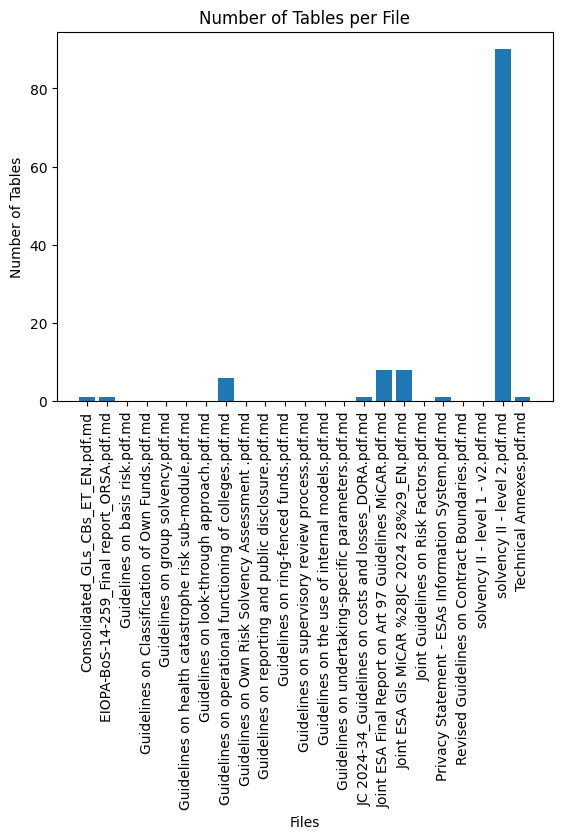

In [ ]:
import os
import re
import matplotlib.pyplot as plt

# src: https://stackoverflow.com/questions/9837935/regex-for-markdown-table-syntax
# https://regex101.com/r/M5wAoq/1/

table_regex = r"^(\|[^\n]+\|\r?\n)((?:\|:?[-]+:?)+\|)(\n(?:\|[^\n]+\|\r?\n?)*)?$"

input_dir = os.path.join("data", "preprocessed-step-3", PROJECT_NAME, "step-3.2-equations", #"substep-1")
output_dir = os.path.join("data", "preprocessed-step-3", PROJECT_NAME, "step-3.3-tables", "substep-1")

def add_table_marker(content):
    def replacer(match):
        table = match.group(0)

        table_formatted = f"\n<table>\n{table}"

        if not table.endswith("\n"):
            table_formatted += "\n"

        table_formatted += "</table>\n"

        return table_formatted

    content = re.sub(table_regex, replacer, content, flags=re.MULTILINE)

    return content

tables_per_file = {}
for file_name in os.listdir(input_dir):
    print(file_name)
    if os.path.isfile(os.path.join(input_dir, file_name)):
        with open(os.path.join(input_dir, file_name), "r", encoding="utf-8") as f:
            content = f.read()
        content = add_table_marker(content)

        # find table size
        matches = re.finditer("<table>(.*?\n)</table>", content, flags=re.DOTALL)
        count = 0
        tables_per_file[file_name] = {}
        tables_per_file[file_name]["table_sizes"] = []
        tables_per_file[file_name]["count"] = 0
        for match in matches:
            image = match.group(1)
            # if not file_name in tables_per_file:
            #     tables_per_file[file_name] = {"count": 0}

            # if not "table_sizes" in tables_per_file[file_name]:
            #     tables_per_file[file_name]["table_sizes"] = []      

            tables_per_file[file_name]["table_sizes"].append(len(image))

            count += 1
            
        tables_per_file[file_name].update({"count": count})

        with open(os.path.join(output_dir, file_name), "w", encoding="utf-8") as f:
            f.write(content)
    else:
        print(f"File skipping... {file_name}")
print(tables_per_file.values())
plt.bar(tables_per_file.keys(), [file_info["count"] for file_info in tables_per_file.values()])
plt.xticks(rotation=90)
plt.xlabel("Files")
plt.ylabel("Number of Tables")
plt.title("Number of Tables per File")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution(tables_per_file, with_vline=True):
    bin_edges = np.arange(0, 10001, 1000)
    for file in tables_per_file:
        print(tables_per_file[file])
        # indexes = [idx for idx, _ in enumerate(tables_per_file[file]["table_sizes"])]
        counts, bins, patches = plt.hist(tables_per_file[file]["table_sizes"], bins=bin_edges, label=file)

        # Annotate each bar
        for count, patch in zip(counts, patches):
            if count > 0:  # only annotate non-empty bins
                # Get bar center
                x = patch.get_x() + patch.get_width() / 2
                y = patch.get_height()
                plt.text(
                    x,
                    y,
                    str(int(count)),
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    rotation=0,
                )

    if with_vline:
        SMALL_TABLE_THRESHOLD = 1000
        MEDIUM_TABLE_THRESHOLD = 4000
        plt.axvline(x=SMALL_TABLE_THRESHOLD, color='red', linestyle='--', linewidth=2, label='Threshold Small Table')
        plt.axvline(x=MEDIUM_TABLE_THRESHOLD, color='blue', linestyle='--', linewidth=2, label='Threshold Medium Table')
        plt.xlabel("Table Size (characters)")
        plt.ylabel("Number of tables")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


{'table_sizes': [639], 'count': 1}
{'table_sizes': [1462], 'count': 1}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [120, 210, 356, 2253, 2678, 2573], 'count': 6}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [1356], 'count': 1}
{'table_sizes': [4016, 2403, 2493, 784, 4053, 3017, 2841, 1518], 'count': 8}
{'table_sizes': [4013, 2403, 2493, 784, 4156, 2924, 3060, 1072], 'count': 8}
{'table_sizes': [], 'count': 0}
{'table_sizes': [1132], 'count': 1}
{'table_sizes': [], 'count': 0}
{'table_sizes': [], 'count': 0}
{'table_sizes': [123, 243, 389, 264, 213, 375, 284, 246, 246, 661, 570, 242, 79, 124, 117, 164, 192, 783, 115, 305, 128, 197, 171, 119, 169, 116, 150, 178, 1213, 902, 3502, 772, 822, 481, 2007

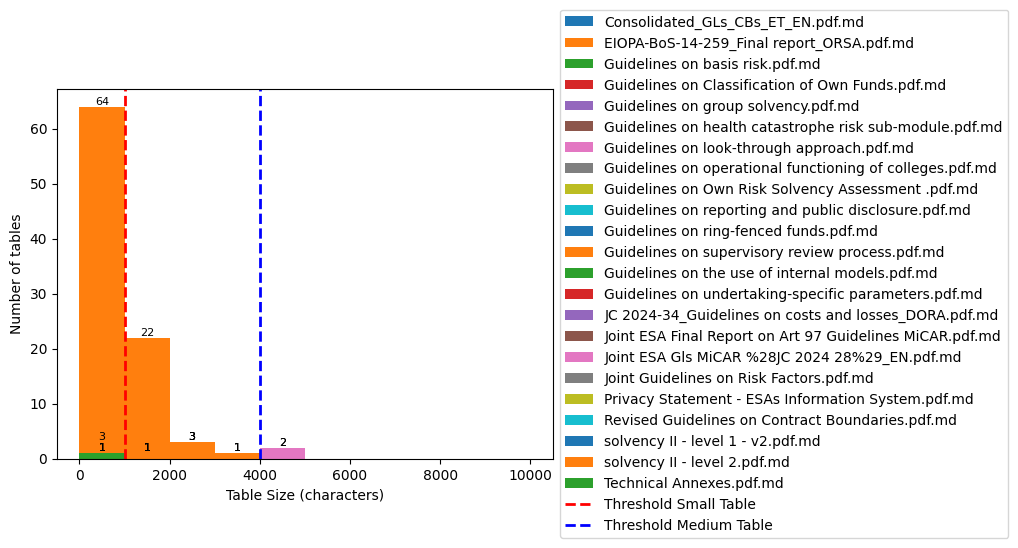

In [ ]:
plot_distribution(tables_per_file)

{'table_sizes': [639, 1462, 120, 210, 356, 2253, 2678, 2573, 1356, 4016, 2403, 2493, 784, 4053, 3017, 2841, 1518, 4013, 2403, 2493, 784, 4156, 2924, 3060, 1072, 1132, 123, 243, 389, 264, 213, 375, 284, 246, 246, 661, 570, 242, 79, 124, 117, 164, 192, 783, 115, 305, 128, 197, 171, 119, 169, 116, 150, 178, 1213, 902, 3502, 772, 822, 481, 2007, 834, 481, 2007, 693, 744, 586, 524, 563, 263, 434, 1354, 1246, 1001, 566, 395, 1236, 138, 560, 121, 1098, 2959, 863, 511, 1681, 1603, 1361, 1019, 231, 1681, 1651, 1404, 469, 1130, 1682, 1429, 1148, 528, 493, 1246, 1126, 746, 313, 940, 1003, 154, 1032, 540, 112, 912, 267, 379, 242, 173, 123, 1478, 602]}


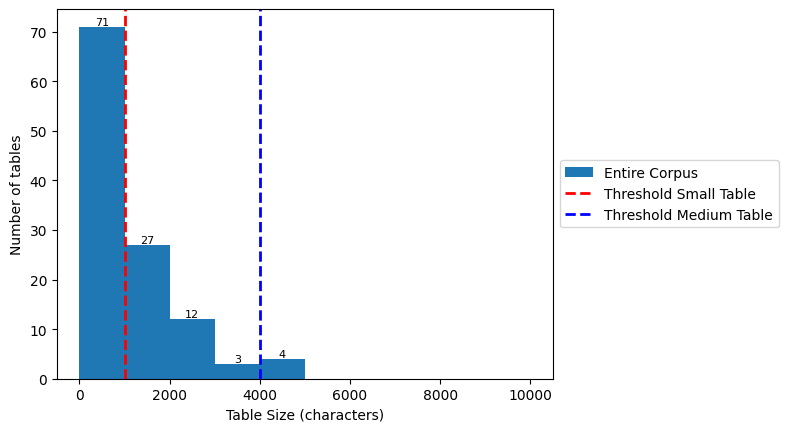

In [ ]:
all_table_sizes = []
for file_name in tables_per_file:
    all_table_sizes.extend(tables_per_file[file_name]["table_sizes"])

plot_distribution({"Entire Corpus": {"table_sizes": all_table_sizes}}, with_vline=True)


Consolidated_GLs_CBs_ET_EN.pdf.md
No more matches, breaking...
{'table_sizes': [637]}
EIOPA-BoS-14-259_Final report_ORSA.pdf.md
No more matches, breaking...
{'table_sizes': [1460]}
Guidelines on basis risk.pdf.md
No more matches, breaking...
{'table_sizes': []}
Guidelines on Classification of Own Funds.pdf.md
No more matches, breaking...
{'table_sizes': []}
Guidelines on group solvency.pdf.md
No more matches, breaking...
{'table_sizes': []}
Guidelines on health catastrophe risk sub-module.pdf.md
No more matches, breaking...
{'table_sizes': []}
Guidelines on look-through approach.pdf.md
No more matches, breaking...
{'table_sizes': []}
Guidelines on operational functioning of colleges.pdf.md
No more matches, breaking...
{'table_sizes': [118, 208, 354, 2251, 2676, 2571]}
Guidelines on Own Risk Solvency Assessment .pdf.md
No more matches, breaking...
{'table_sizes': []}
Guidelines on reporting and public disclosure.pdf.md
No more matches, breaking...
{'table_sizes': []}
Guidelines on ring-

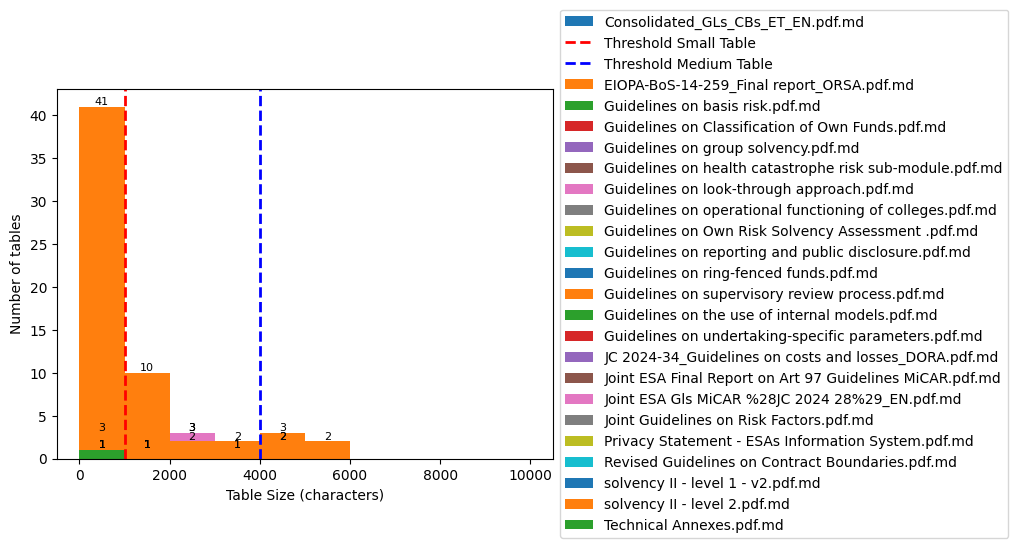

In [227]:
def merge_tables(content):
    mergeable_table_regex = r"(<table>\n*(\|[^\n]+\|\r?\n)((?!</table>).)*?)\n*</table>(\n*--- Page \d+ ---\n*)+<table>\n*(\|[^\n]+\|\r?\n)((?:\|:?[-]+:?)+\|)(.*?\n*</table>)"

    matches = re.finditer(mergeable_table_regex, content, flags=re.DOTALL)

    # print(f"Number of matches (non-strict) {len(list(matches))}")

    strict_matches = []
    for match in matches:
        # print(match.group(1))
        # if "|Zone/<br>Region|AT|BE|CH|CZ|DE|DK|ES|FR|IE|NL|NO|PL|SE|UK|" in match.group(2):
        #     print("Found specific table:")
        #     print(match.group(2) == match.group(5))
        #     print(match.group(2))
        #     print(match.group(5))
        if match.group(2) == match.group(5):
            strict_matches.append(match)

    return strict_matches


input_dir = r"data\preprocessed-step-3\solvency-II-files\step-3.3-tables\substep-1"
output_dir = r"data\preprocessed-step-3\solvency-II-files\step-3.3-tables\substep-2"
# output_dir_TEMP = r"..\data\preprocessed-step-final\solvency-II-files"
# output_dir = output_dir_TEMP

with_vline = True

for file_name in os.listdir(input_dir):
    print(file_name)
    if os.path.isfile(os.path.join(input_dir, file_name)):
        with open(os.path.join(input_dir, file_name), "r", encoding="utf-8") as f:
            content = f.read()

        # file_name = "final_solvency II - level 2.pdf.md"
        # with open(output_dir + "\\" + file_name, "r", encoding="utf-8") as f:
        #     content = f.read()

        strict_matches = merge_tables(content)

        # print(f"Found number of matches {len(strict_matches)}")
        # for idx, match in enumerate(matches):
        #     print(f"*** Match {idx}: ***")
        #     print(match.group(0))
        #     print(f"*** End of match {idx} ***")

        while True:
            if not strict_matches:
                print("No more matches, breaking...")
                break
            print(f"Found number of matches {len(strict_matches)}")
            print(f"Original content length: {len(content)}")
            for idx, match in enumerate(strict_matches):
                # print(match.group(0))
                # print(f"*** Replacing for match {idx}: ***")
                content = content.replace(match.group(0), match.group(1) + match.group(7) + "\n" + match.group(4))
            print(f"New content length: {len(content)}")

            strict_matches = merge_tables(content)
            # previous_number_merge_tables = number_merge_tables
            # number_merge_tables = len(strict_matches)

        # root_new_new = "table-examples-out-2"
        with open(output_dir + "\\" + file_name, "w", encoding="utf-8") as f:
            f.write(content)


        table_sizes = []
        for match in re.finditer(table_regex, content, flags=re.MULTILINE):
            table_size = len(match.group(0))
            table_sizes.append(table_size)
            # if table_size > MEDIUM_TABLE_THRESHOLD:
            #     print(f"Large table size: {table_size}")
            #     print(f"content\n {match.group(0)}\n ")

        plot_distribution({file_name: {"table_sizes": table_sizes}}, with_vline=with_vline)
        if with_vline:
            with_vline = False

In [228]:
# save final documents for manual inspection
import os
final_substep_dir = r"data\preprocessed-step-3\solvency-II-files\step-3.3-tables\substep-2"
for file_name in loaded_docs:
    # save
    with open(os.path.join("data", "preprocessed-step-3", PROJECT_NAME, "_final", file_name + ".md"), 'w', encoding='utf-8') as final_f:
        with open(os.path.join(final_substep_dir, file_name + ".md"), 'r', encoding='utf-8') as last_step_f:
            final_f.write(last_step_f.read())

# Chunking Strategy

## Notes on chunking strategy
* Markdown formatting not preserved by MarkdownTextSplitter
    * Resolution
Switched from MarkdownTextSplitter
to 
ExperimentalMarkdownSyntaxTextSplitter

main reason was newlines were removed within the markdown for no apperent reason,
which broke formatting e.g. with

42

----

becoming

This is a all bold
42
-----

Which is just \n characters which are removed from the original file

```
This is a all bold
42
-----
```
* Table being cut in middle of chunk
    * Additionally I had problems with tables getting cut of, not sure if resolved yet, e.g. if it is recusrivetextsplitter problem, markdowntextsplitter, or combination.
* Multipage table not being interpret correct through the markdown
![image.png](attachment:image.png)

In [278]:
import re
from typing import List, Any
from langchain_text_splitters import RecursiveCharacterTextSplitter

class TagAwareRecursiveCharacterTextSplitter(RecursiveCharacterTextSplitter):
    """
    A text splitter that preserves content within specified XML-like tags
    while still splitting naturally on paragraphs and other separators.
    """
    
    def __init__(
        self,
        protected_tags: List[str] = None,
        **kwargs: Any,
    ) -> None:
        """
        Initialize the tag-aware text splitter.
        
        Args:
            protected_tags: List of tag names to protect (e.g., ['image', 'table', 'equation'])
            **kwargs: All other arguments passed to RecursiveCharacterTextSplitter
        """
        super().__init__(**kwargs)
        self.protected_tags = protected_tags or ['image', 'table', 'equation']
        
        # Create regex pattern to match protected tag blocks
        tag_patterns = []
        for tag in self.protected_tags:
            # Match opening tag, content (non-greedy), and closing tag
            pattern = f"<{tag}[^>]*>.*?</{tag}>"
            tag_patterns.append(pattern)
        
        self.protected_pattern = "|".join(f"({pattern})" for pattern in tag_patterns)
    
    def _extract_protected_blocks(self, text: str) -> tuple[List[str], List[str]]:
        """
        Extract protected tag blocks from text and return placeholders and blocks.
        
        Returns:
            tuple: (text_with_placeholders, protected_blocks)
        """
        protected_blocks = []
        
        def replace_match(match):
            block = match.group(0)
            placeholder = f"__PROTECTED_BLOCK_{len(protected_blocks)}__"
            protected_blocks.append(block)
            return placeholder
        
        # Replace all protected blocks with placeholders
        text_with_placeholders = re.sub(
            self.protected_pattern, 
            replace_match, 
            text, 
            flags=re.DOTALL
        )
        
        return text_with_placeholders, protected_blocks
    
    def _restore_protected_blocks(self, chunks: List[str], protected_blocks: List[str]) -> List[str]:
        """
        Restore protected blocks in the final chunks.
        """
        restored_chunks = []
        
        for chunk in chunks:
            restored_chunk = chunk
            # Replace placeholders with original protected blocks
            for i, block in enumerate(protected_blocks):
                placeholder = f"__PROTECTED_BLOCK_{i}__"
                restored_chunk = restored_chunk.replace(placeholder, block)
            restored_chunks.append(restored_chunk)
        
        return restored_chunks
    
    def split_text(self, text: str) -> List[str]:
        """
        Split text while preserving protected tag blocks.
        """
        # Step 1: Extract protected blocks and replace with placeholders
        text_with_placeholders, protected_blocks = self._extract_protected_blocks(text)
        
        # Step 2: Use parent class's split_text method
        chunks_with_placeholders = super().split_text(text_with_placeholders)
        
        # Step 3: Restore protected blocks in the final chunks
        final_chunks = self._restore_protected_blocks(
            chunks_with_placeholders, protected_blocks
        )
        
        return final_chunks

In [ ]:
import os
from langchain_text_splitters.markdown import ExperimentalMarkdownSyntaxTextSplitter
# from langchain_community.document_loaders import DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from copy import deepcopy

DIRECTORY_TO_EMBED = os.path.join("data", "preprocessed-step-3", PROJECT_NAME, "_final")

for file_name in loaded_docs:
    with open(os.path.join(DIRECTORY_TO_EMBED, file_name + ".md"), 'r', encoding="utf-8") as f:
        markdown_file = f.read()

    loaded_docs[file_name].page_content = markdown_file

markdown_splitter = ExperimentalMarkdownSyntaxTextSplitter()

markdown_split_documents = []

page_delimiter_regex = r"\n--- Page \d+ ---\n"

for filename, doc in loaded_docs.items():
    print(f"READING FILE {doc.metadata}")
    # This returns a list of NEW documents that ONLY have header metadata.
    new_splits = markdown_splitter.split_text(doc.page_content)

    # Update page_number metadata
    current_page_number = 1
    
    print(f"Resulting splits {len(new_splits)}\n")
    for chunk in new_splits:
        # update split metadata to include page number and total pages
        chunk.metadata["page_number"] = current_page_number

        combined_metadata = deepcopy(doc.metadata)
        combined_metadata.update(chunk.metadata)
        
        markdown_split_document = Document(
            page_content=chunk.page_content,
            metadata=combined_metadata
        )
        
        markdown_split_documents.append(markdown_split_document)

        # update current page number (WILL BE REPLACED WITH CHUNK LEVEL PAGE DELIMITER)
        pageDelimiters = re.findall(page_delimiter_regex, chunk.page_content)
        lastPageDelimiter = pageDelimiters[-1] if pageDelimiters else None

        if lastPageDelimiter:
            current_page_number = int(lastPageDelimiter.split("--- Page ")[1].split(" ---")[0])

print(f"Number of markdown splits made {len(markdown_split_documents)} vs number of orginal documents {len(loaded_docs)}")

MAGIC_CHUNK_SIZE = 1000 # Each chunk will be 1000 characters
MAGIC_CHUNK_OVERLAP = 200 # Overlap of 200 characters between chunks

# handed to RecursiveCharacterTextSplitter
kwargs = {
    "chunk_size": MAGIC_CHUNK_SIZE,
    "chunk_overlap": MAGIC_CHUNK_OVERLAP,
    "separators": ["\n\n", "\n", " ", ""]
}

tag_aware_splitter = TagAwareRecursiveCharacterTextSplitter(
    protected_tags=['image', 'table', 'equation'],
    **kwargs
)

# Split the text
docs = tag_aware_splitter.transform_documents(markdown_split_documents)

with open(os.path.join("data", "chunking-step-1", file_name + ".md"), "w", encoding="utf-8") as f:
    for i, chunk in enumerate(docs):
        f.write(f"****** Chunk {i + 1}: *****\n")
        f.write(chunk.page_content)
        f.write("\n****** END OF CHUNK ******\n\n")  # Add double newlines between chunks


print(f"Number of {len(docs)} chunks vs markdown splits made {len(markdown_split_documents)} ")

READING FILE {'producer': 'Adobe PDF Library 22.3.86', 'creator': 'Acrobat PDFMaker 22 for Word', 'creationdate': '2023-03-10T09:04:19+01:00', 'source': 'data\\raw\\solvency-II-files\\guidelines-level 3-v0.1 - TRUNCATED\\Consolidated_GLs_CBs_ET_EN.pdf', 'file_path': 'data\\raw\\solvency-II-files\\guidelines-level 3-v0.1 - TRUNCATED\\Consolidated_GLs_CBs_ET_EN.pdf', 'total_pages': 18, 'format': 'PDF 1.6', 'title': 'Guidelines on Contract Boundaries – Consolidated Version with Explanatory Text', 'author': 'Miguel Caballero', 'subject': '', 'keywords': '', 'moddate': '2023-03-10T09:04:32+01:00', 'trapped': '', 'modDate': "D:20230310090432+01'00'", 'creationDate': "D:20230310090419+01'00'", 'short_title': 'CB Guidelines (Consolidated)'}
Resulting splits 9

READING FILE {'producer': 'Microsoft® Word 2010', 'creator': 'Microsoft® Word 2010', 'creationdate': '2015-07-09T10:56:50+02:00', 'source': 'data\\raw\\solvency-II-files\\guidelines-level 3-v0.1 - TRUNCATED\\EIOPA-BoS-14-259_Final report

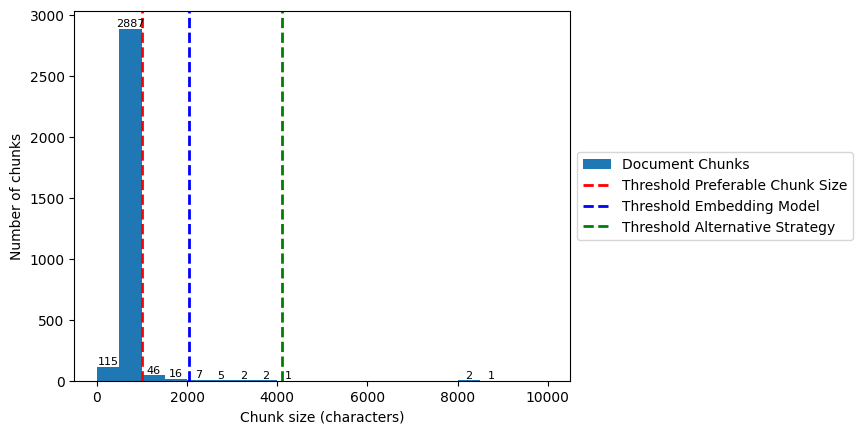

In [275]:
lengths_of_chunks = [len(chunk.page_content) for chunk in docs]

bin_edges = np.arange(0, 10001, 500)
counts, bins, patches = plt.hist(lengths_of_chunks, bins=bin_edges, label="Document Chunks")

# Annotate each bar
for count, patch in zip(counts, patches):
    if count > 0:  # only annotate non-empty bins
        # Get bar center
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        plt.text(
            x,
            y,
            str(int(count)),
            ha="center",
            va="bottom",
            fontsize=8,
            rotation=0,
        )

PREFERABLE_CHUNK_SIZE = 1000
# MEDIUM_TABLE_THRESHOLD = 4000
THRESHOLD_EMBEDDING_MODEL = 2048
THRESHOLD_ALTERNATIVE_STRATEGY = 4096
plt.axvline(x=PREFERABLE_CHUNK_SIZE, color='red', linestyle='--', linewidth=2, label='Threshold Preferable Chunk Size')
plt.axvline(x=THRESHOLD_EMBEDDING_MODEL, color='blue', linestyle='--', linewidth=2, label='Threshold Embedding Model')
plt.axvline(x=THRESHOLD_ALTERNATIVE_STRATEGY, color='green', linestyle='--', linewidth=2, label='Threshold Alternative Strategy')
plt.xlabel("Chunk size (characters)")
plt.ylabel("Number of chunks")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [283]:
chunk.__dict__

{'id': None,
 'metadata': {'producer': 'PDFlib+PDI 8.0.5p2 (C++/Win64)',
  'creator': 'Arbortext Advanced Print Publisher 11.0.3108/W Unicode-x64',
  'creationdate': '2015-01-15T14:01:49+01:00',
  'source': 'data\\raw\\solvency-II-files\\solvency II - level 2.pdf',
  'file_path': 'data\\raw\\solvency-II-files\\solvency II - level 2.pdf',
  'total_pages': 797,
  'format': 'PDF 1.4',
  'title': 'COMMISSION  DELEGATED  REGULATION  (EU)  2015/  35  -  of  10  October  2014  -  supplementing  Directive  2009/  138/  EC  of  the  European  Parliament  and  of  the  Council  on  the  taking-up  and  pursuit  of  the  business  of  Insurance  and  Reinsurance  (Solvency  II)',
  'author': 'Publications Office',
  'subject': '',
  'keywords': '',
  'moddate': '2015-01-15T16:48:08+01:00',
  'trapped': '',
  'modDate': "D:20150115164808+01'00'",
  'creationDate': "D:20150115140149+01'00'",
  'short_title': 'Solvency II – Level 2 Regulation',
  'Header 1': '_ANNEX XXI_',
  'page_number': 292},
 'p

In [230]:
import pprint
# evaluating markdown split quality
# MAGIC_LENGTH = 1000 # will need recursive splitting
MAGIC_LENGTH = MAGIC_CHUNK_SIZE * 10 # may be suboptimal
count_number_of_markdown_splits_to_big_grouped_per_source = {}
for markdown_split_document in markdown_split_documents:
    if len(markdown_split_document.page_content) > MAGIC_CHUNK_SIZE:
        if markdown_split_document.metadata["source"] not in count_number_of_markdown_splits_to_big_grouped_per_source:
            count_number_of_markdown_splits_to_big_grouped_per_source[markdown_split_document.metadata["source"]] = 1
        count_number_of_markdown_splits_to_big_grouped_per_source[markdown_split_document.metadata["source"]] += 1
        # print(f"[WARNING] {markdown_split_document.metadata["source"]}")
    
    if len(markdown_split_document.page_content) > MAGIC_LENGTH:
        print(f"\n\n\n[WARNING] Markdown split may be suboptimal {markdown_split_document.metadata['source']} has a split with length {len(markdown_split_document.page_content)} which is larger than {MAGIC_LENGTH} characters")
        print(f"********* PAGE CONTENT FOR TO LARGE MARKDOWN SPLIT *********")
        print(markdown_split_document.page_content)
        print(f"********* END OF PAGE CONTENT FOR TO LARGE MARKDOWN SPLIT *********\n\n\n")
        # print("----")

pprint.pprint(count_number_of_markdown_splits_to_big_grouped_per_source)




[WARNING] Markdown split may be suboptimal data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Consolidated_GLs_CBs_ET_EN.pdf has a split with length 13382 which is larger than 10000 characters
********* PAGE CONTENT FOR TO LARGE MARKDOWN SPLIT *********
Insurance and reinsurance undertakings should assess whether at recognition date it is possible to unbundle a contract and, at each valuation date, consider whether there has been any change, which would affect the previous assessment.
Insurance and reinsurance undertakings should consider that a contract can be unbundled for the purpose of contract boundaries if and only if two (or more) parts of the contract are equivalent in terms of risk to two (or more) contracts that could be sold separately. For the purposes of this Guideline, two contracts should be considered to be equivalent in terms of risk if there are no discernible differences in the economics of the contracts regarding the insurance or financial risk borne 

In [231]:
# update page_number

# update current page number on chunk level
# override page number

current_page_number = 1
relaxed_page_delimiter_regex = r"--- Page \d+ ---"  # relaxed regex to match page delimiters
current_source = None
for chunk in chunks:
    if current_source != chunk.metadata["source"]:
        # reset page number if source changes
        current_page_number = 1
        current_source = chunk.metadata["source"]

    combined_metadata = deepcopy(chunk.metadata)
    combined_metadata["page_number"] = current_page_number
    chunk.metadata = combined_metadata
    
    pageDelimiters = re.findall(relaxed_page_delimiter_regex, chunk.page_content)
    lastPageDelimiter = pageDelimiters[-1] if pageDelimiters else None

    if lastPageDelimiter:
        current_page_number = int(lastPageDelimiter.split("--- Page ")[1].split(" ---")[0])



In [232]:
# REMOVE PAGE NUMBER DELIMITER
total_number_of_page_delimiter_removed = 0
for chunk in chunks:
    # remove page number delimiter
    (chunk.page_content, number_of_page_delimiter_removed)= re.subn(relaxed_page_delimiter_regex, "", chunk.page_content)
    # print(f"Removed {number_of_page_delimiter_removed} page delimiters from chunk")

    total_number_of_page_delimiter_removed += number_of_page_delimiter_removed
    # remove empty lines
    # chunk.page_content = re.sub(r'\n\s*\n', '\n', chunk.page_content)

print(f"Total number of page delimiters removed {total_number_of_page_delimiter_removed}")

Total number of page delimiters removed 851


In [233]:
# update page number based on delimiters:
# see chunks in text format
with open(os.path.join("data", "chunking-step-1", "chunks-with-page-numbers.txt"), 'wb') as f:
    for chunk in chunks:
        # print(chunk.page_content)
        # print(chunk.metadata)

        f.write(f'\n--- METADATA Source {chunk.metadata["source"]} ---'.encode('utf-8'))
        f.write(f"\n--- METADATA Page {chunk.metadata['page_number']} ---".encode('utf-8'))
        f.write(f"\n--- Start of Chunk ---\n\n".encode('utf-8'))
        f.write(chunk.page_content.encode('utf-8'))
        f.write(b"\n--- End of Chunk ---\n\n")

## Validating chunking strategy

In [234]:
with open(os.path.join("data", "chunking-step-1", "markdown_splits.txt"), "wb") as f:
    for markdown_split_document in markdown_split_documents:
        header_1 = markdown_split_document.metadata.get("Header 1", "")
        header_2 = markdown_split_document.metadata.get("Header 2", "")
        header_3 = markdown_split_document.metadata.get("Header 3", "")
        header_4 = markdown_split_document.metadata.get("Header 4", "")
        header_5 = markdown_split_document.metadata.get("Header 5", "")
        heading_hierarchy = [header_1, header_2, header_3, header_4, header_5]
        f.write(f"\n\n--- Begin of split ---\n".encode('utf-8'))
        f.write(f"Header hierachy : {heading_hierarchy}\n".encode('utf-8'))
        f.write(f"--- Source: {markdown_split_document.metadata['source']} ---\n".encode('utf-8'))
        f.write(markdown_split_document.page_content.encode('utf-8'))
        f.write(f"\n\n--- End of split ---\n\n".encode('utf-8'))

In [158]:
# doc = pymupdf.open(r"C:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Consolidated_GLs_CBs_ET_EN.pdf")
# import pymupdf4llm
# page_number = 7
# output_dir = "playground"
# for page in [doc[page_number - 1]]:
#     print(page.get_images(full=True))
#     for image in page.get_images(full=True):
#         xref = image[0]
#         image_data = doc.extract_image(xref)

#         with open(os.path.join(output_dir, f"image-page-{page_number}-{xref}.{image_data['ext']}"), "wb") as img_file:
#             img_file.write(image_data["image"])

#     # for vector_graphic in page.get_drawings():
#     #     # xref = vector_graphic[0]
#     #     print(vector_graphic)
#     #     # vector_data = doc.extract_vector(xref)

#     #     with open(os.path.join(output_dir, f"vector-page-{page_number}-{xref}.svg"), "wb") as vector_file:
#     #         vector_file.write(vector_data["vector"])


#     with open(os.path.join(output_dir, f"text-page-{page_number}-{xref}.txt"), "w", encoding="utf-8") as text_file:
#         text_file.write(page.get_text())

#     kwargs = {'table_strategy': 'lines_strict', 'image_size_limit': 0.03, 'graphics_limit': 5000, 'write_images': True, 'image_path': os.path.join(output_dir, "temp")}
#     markdown = pymupdf4llm.to_markdown(doc, pages=[page_number - 1], **kwargs)

#     with open(os.path.join(output_dir, f"markdown-page-{page_number}-{xref}.md"), "w", encoding="utf-8") as md_file:
#         md_file.write(markdown)

In [35]:
# verify markdown splits

# metadata of level 1 and level 2
# BOTH ARE VERIFIED

level_1_structure = {
    "TITLES": [],
    "CHAPTERS": [],
    "SECTIONS": [],
    "SUBSECTIONS": [],
    "ARTICLES": []
}

level_2 = {
    "TITLES": [],
    "CHAPTERS": [],
    "SECTIONS": [],
    "SUBSECTIONS": [],
    "ARTICLES": []
}

verifiable_levels = [{"source": "data\\raw\\solvency-II-files\\solvency II - level 1 - v2.pdf", "level_structure": level_1_structure, "expected_structure": structure_solvency_II_level_1}, {"source": "data\\raw\\solvency-II-files\\solvency II - level 2.pdf", "level_structure": level_2, "expected_structure": structure_solvency_II_level_2}]

for level_to_verify in verifiable_levels:
    print(f"\n**** VERIFYING LEVEL OF {level_to_verify['source']} ****")
    level_1_structure = level_to_verify["level_structure"]
    source = level_to_verify["source"]
    expected_structure = level_to_verify["expected_structure"]

    no_header_counter= 0
    total_markdown = 0
    total_markdown = 0
    current_header_2 = None
    current_header_3 = None
    current_header_4 = None
    current_header_5 = None
    total_sections = 0
    article_numbering = []
    has_invalid_header_1 = False
    has_invalid_header_2 = False
    has_invalid_header_3 = False
    has_invalid_header_4 = False
    has_invalid_header_5 = False

    for idx, chunk in enumerate(markdown_split_documents):
        if chunk.metadata["source"] == source:
            header_1 = chunk.metadata.get('Header 1')
            header_2 = chunk.metadata.get('Header 2')
            header_3 = chunk.metadata.get('Header 3')
            header_4 = chunk.metadata.get('Header 4')
            header_5 = chunk.metadata.get('Header 5')


            # print(f"Split: On page {split.metadata['page_number']}, {header_1}, {header_2}, {header_3}, {header_4}, {header_5}")
                
            if header_1:
                if not (header_1.startswith("TITLE") or header_1.startswith("_ANNEX")):
                    print(f"Header 1 {header_1} is not a valid title, skipping")
                    has_invalid_header_1 = True
                    continue

                if header_1 not in level_1_structure["TITLES"] and header_1.startswith("TITLE"):
                    level_1_structure["TITLES"].append(header_1)
            else:
                no_header_counter += 1
                print(f"No header found for split on page {chunk.metadata['page_number']}")
            
            if header_2 and current_header_2 != header_2:
                # new chapter
                if "CHAPTER" in header_2:
                    level_1_structure["CHAPTERS"].append(header_2)
                else:
                    print(f"[ERROR] Non default header_2, {header_2}")
                    has_invalid_header_2 = True

                current_header_2 = header_2

            if header_3 and current_header_3 != header_3:
                if "Section" in header_3:
                    level_1_structure["SECTIONS"].append(header_3)
                else:
                    print(f"[ERROR] Non default header_3, {header_3}")
                    has_invalid_header_3 = True

                current_header_3 = header_3
                total_sections += 1

            if header_4 and current_header_4 != header_4:
                if "Subsection" in header_4:
                    level_1_structure["SUBSECTIONS"].append(header_4)
                else:
                    print(f"[ERROR] Non default header_4, {header_4}")
                    has_invalid_header_4 = True

                current_header_4 = header_4
            
            if header_5 and current_header_5 != header_5:
                
                if "Article" in header_5:
                    level_1_structure["ARTICLES"].append(header_5)
                    # print(header_5.split("Article ")[1])
                    article_numbering.append(header_5.split("Article ")[1])
                else:
                    print(f"[ERROR] Non default header_5, {header_5}")
                    has_invalid_header_5 = True


                current_header_5 = header_5

            total_markdown += 1

    print(f"Number of splits without header {no_header_counter} of total {total_markdown} splits")

    print(f"Total sections found: {total_sections}, where we expect at least (so >=) {expected_structure['NUM_SECTIONS']}")


    for key, value in level_1_structure.items():
        if len(value) != expected_structure["NUM_" + key]:
            print(f"Mismatch in {key}: {len(value)} found, {expected_structure['NUM_' + key]} expected")
        else:
            print(f"Verified {key}, as expected")


    prev_number = 0
    has_invalid_article_number = False
    for article_number in article_numbering:
        if re.match(r"\d+[a-z]" , article_number):
            print(f"Article number {article_number} has a letter suffix, skipping")
            continue 

        if int(article_number) != prev_number + 1:
            has_invalid_article_number = True
            print(f"Article number {article_number} is NOT in sequence with previous article number {prev_number}")

        prev_number = int(article_number)

    if not has_invalid_article_number:
        print(f"[SUCCESS] All article numbers are in sequence as expected")
    for idx, invalid_header in enumerate([has_invalid_header_1, has_invalid_header_2, has_invalid_header_3, has_invalid_header_4, has_invalid_header_5]):
        if invalid_header:
            print(f"[ERROR] Invalid header {idx + 1} found in level  {level_to_verify['source']}")

    print(f"**** END OF VERIFYING LEVEL ****")



# On page 73, TITLE II, *CHAPTER I*, Section 3 && n page 74, TITLE II, *CHAPTER I*, Section 5 
# known bug of PDF to .md conversion is Title II, Chapter I, Section 4 'Conditions of insurance and scales of premium
# two column layout not detected correctly. Both section 4 and 5 are at the top. Section 4 is left empty.
# all the information of this section is placed in section 5.

# import re
# prev_number = 0
# for article_number in article_numbering:
#     if re.match(r"\d+[a-z]", article_number):
#         print(f"Article number {article_number} has a letter suffix, skipping")
#         continue
#     if int(article_number) != prev_number + 1:
#         print(article_number, "is not in sequence with previous article number", prev_number)
    
#     prev_number = int(article_number)


**** VERIFYING LEVEL OF data\raw\solvency-II-files\solvency II - level 1 - v2.pdf ****
No header found for split on page 1
No header found for split on page 1
[ERROR] Non default header_2, I
No header found for split on page 1
[ERROR] Non default header_2, DIRECTIVES
Header 1 √ is not a valid title, skipping
Header 1 ~~√~~ is not a valid title, skipping
Header 1 √ is not a valid title, skipping
Header 1 ~~√~~ is not a valid title, skipping
Number of splits without header 3 of total 419 splits
Total sections found: 41, where we expect at least (so >=) 41
Verified TITLES, as expected
Verified CHAPTERS, as expected
Verified SECTIONS, as expected
Verified SUBSECTIONS, as expected
Mismatch in ARTICLES: 316 found, 312 expected
Article number 17b has a letter suffix, skipping
Article number 17c has a letter suffix, skipping
Article number 17d has a letter suffix, skipping
Article number 21b has a letter suffix, skipping
[SUCCESS] All article numbers are in sequence as expected
[ERROR] Invali

Related to Mismatch in ARTICLES: 316 found, 312 expected
The cause is a weird sub from another directive causes more articles (312 + 4):
* Article number 17b
* Article number 17c
* Article number 17d
* Article number 21b


In [125]:
chunks_per_page_level_1 = {}
chunks_per_page_level_2 = {}

for chunk in chunks:
    # print(chunk.metadata["page_number"])
    # print_chunk(chunk)
    if chunk.metadata['source'] == "data\\raw\\solvency-II-files\\solvency II - level 1 - v2.pdf":
        # if chunk.metadata["page_number"] == 125:
        #     # print(f"Metadata of annex")

        page.number = chunk.metadata["page_number"]
        if page.number not in chunks_per_page_level_1:
            chunks_per_page_level_1[page.number] = 0
        chunks_per_page_level_1[page.number] += 1
    elif chunk.metadata['source'] == "data\\raw\\solvency-II-files\\solvency II - level 2.pdf":
        page.number = chunk.metadata["page_number"]
        if page.number not in chunks_per_page_level_2:
            chunks_per_page_level_2[page.number] = 0
        chunks_per_page_level_2[page.number] += 1


chunks_per_page_sorted_solvency_1 = dict(sorted(chunks_per_page_level_1.items()))
chunks_per_page_sorted_solvency_2 = dict(sorted(chunks_per_page_level_2.items()))

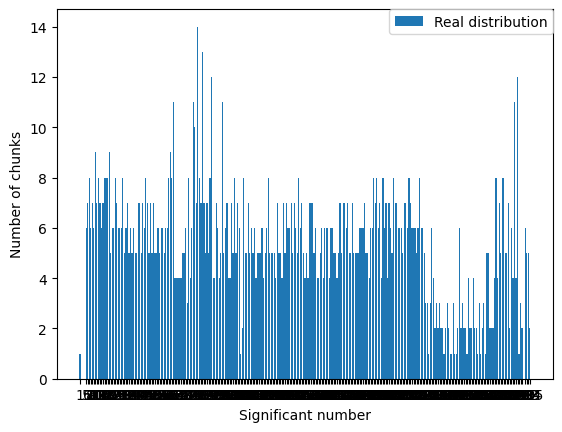

In [126]:
import matplotlib.pyplot as plt
import numpy as np

x = chunks_per_page_sorted_solvency_2
keys = x.keys()
vals = x.values()

plt.bar(keys, vals, label="Real distribution")

# plt.ylim(0,1)
plt.ylabel ('Number of chunks')
plt.xlabel ('Significant number')
plt.xticks(list(keys))
plt.legend (bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)

plt.show()

# Creating document embeddings

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_chroma import Chroma
import warnings
import time

def safe_save_to_vector_store(COLLECTION_NAME, PERSIST_DIRECTORY, embedding_model, chunks):
    """
        # EXAMPLE ON HOW TO USE MultiVectorRetriever
        from langchain.retrievers.multi_vector import MultiVectorRetriever
        from langchain.storage import InMemoryByteStore

        vectorstore = Chroma(COLLECTION_NAME, embedding_model, persist_directory=PERSIST_DIRECTORY)

        # NOTE: ENTIRE DOCSTORE IS SAVED AS A PICKLE FILE FOR PROOF OF CONCEPT
        # load in list(zip(chunk_ids, chunks))
        with open(os.path.join("doc_stores", "table_data.pkl"), "rb") as f:
            doc_store = pickle.load(f)

        byte_store = InMemoryByteStore()
        id_key = "parent_doc_id"

        retriever = MultiVectorRetriever(
            vectorstore=vectorstore,
            byte_store=byte_store,
            id_key=id_key,
        )

        retriever.docstore.mset(doc_store)
    """
    # In memory vector store for testing only
    # vectorstore = InMemoryVectorStore(embedding_model)
    # create a database with vector embedding and documents.
    vectorstore = Chroma(COLLECTION_NAME, embedding_model, persist_directory=PERSIST_DIRECTORY)
    print(f"Current the vector store has: {vectorstore._collection.count()}")

    print(f"RUNNING FOR COLLECTION_NAME: {COLLECTION_NAME}")

    if vectorstore._collection.count() != 0:
        warnings.warn("You are adding to a non-empty collection!")

    # Idea maybe use with retry
    # A lot of people with similar issue on both google forum and https://github.com/langchain-ai/langchain/issues/22241

    # note: behavior of from_documents is to add if vectorstore already exists
    delete_vector_store_check = input("Do you want to delete the vector_store before adding these documents?")
    if delete_vector_store_check == "Y":
        Chroma.delete_collection(Chroma(COLLECTION_NAME, embedding_model, persist_directory=PERSIST_DIRECTORY))

    # Save a new vector store based on config at top of this file (create_vector_store.ipynb)
    check = input("Are you sure you want to run this command? Creating a vectorstore will append to the existing vectorstore and may incur high costs (Y/n)")

    if check == "Y":
        # sanity checks, each enriched_chunk should reference to the original chunk within the docstore
        for enriched_chunk in enriched_chunks:
            if not (id_key in enriched_chunk.metadata and enriched_chunk.metadata[id_key] is not None):
                raise ValueError(f"Enriched chunk is missing required metadata field: {id_key}")
            if not (enriched_chunk.metadata[id_key] in chunk_ids):
                raise ValueError(f"Enriched chunk has invalid {id_key}: {enriched_chunk.metadata[id_key]}")
            
        # sanity check
        if len(chunk_ids) != len(chunks):
            raise ValueError("Chunk IDs and chunks must be of the same length")
        
        print("CHECKS PASTED. CREATING A NEW VECTOR STORE AND DOC STORE AT SPECIFIED LOCATION")

        vectorstore = Chroma.from_documents(enriched_chunks, embedding_model, collection_name=COLLECTION_NAME, persist_directory=PERSIST_DIRECTORY)
        print(vectorstore._collection.count())

        # Persist the documents.
        with open(os.path.join("doc_stores", "table_data.pkl"), "wb") as f:
            doc_store = list(zip(chunk_ids, chunks))
            pickle.dump(doc_store, f)


In [ ]:
from langchain_openai import AzureOpenAIEmbeddings

# Set your Azure OpenAI credentials
embedding_api_key = os.getenv("AZURE_OPENAI_API_KEY")
# print(api_key)

# Create an AzureOpenAIEmbeddings object
embedding_model = AzureOpenAIEmbeddings(
    model="text-embedding-3-large",
    azure_endpoint="https://openai-playground-bjorn.openai.azure.com/",
    api_version="2024-02-01",
    api_key=embedding_api_key
)

#config
import os
COLLECTION_NAME = "OPENAI_SOLVENCY_II_V3" #name of the collection
PERSIST_DIRECTORY = os.path.join("data", "vector_stores", PROJECT_NAME)

#os.path.join( "data", "solvency-II-files", "solvency II - level 1 - v2.pdf")

safe_save_to_vector_store(COLLECTION_NAME, PERSIST_DIRECTORY, embedding_model)


Current the vector store has: 0
RUNNING FOR COLLECTION_NAME: OPENAI_SOLVENCY_II_V2.2
CREATING A NEW VECTOR STORE AT SPECIFIED LOCATION
3697


In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
# from langchain_core.documents import Document
import os
import time

model = "gemini-embedding-001"
# model = "gemini-embedding-exp-03-07"
# model = "text-embedding-004"

# from functools import partial

embedding_model = GoogleGenerativeAIEmbeddings(
        model=f"models/{model}", 
        google_api_key=os.environ["GOOGLE_API_KEY"],
        # request_options={'timeout': 10} #{"initial": 70, "multiplier": 2} --> DOES NOT WORK, NOT CONNECTED.
    )

COLLECTION_NAME = "GEMINI_SOLVENCY_II_V3" #name of the collection
PERSIST_DIRECTORY = os.path.join("data", "vector_stores", PROJECT_NAME)




# vectorstore = Chroma(COLLECTION_NAME, embedding_model, persist_directory=PERSIST_DIRECTORY)

# documents = [Document(document) for document in documents_str]

safe_save_to_vector_store(COLLECTION_NAME, PERSIST_DIRECTORY, embedding_model)

Current the vector store has: 0
RUNNING FOR COLLECTION_NAME: GEMINI_SOLVENCY_II_V1
CREATING A NEW VECTOR STORE AT SPECIFIED LOCATION
Sending batch requests 0...
Sending batch requests 1...
Sending batch requests 2...
Sending batch requests 3...
Sending batch requests 4...
Sending batch requests 5...
Sending batch requests 6...
Sending batch requests 7...
Sending batch requests 8...
Sending batch requests 9...
Sending batch requests 10...
Sending batch requests 11...
Sending batch requests 12...
Sending batch requests 13...
Sending batch requests 14...
Sending batch requests 15...
Sending batch requests 16...
Sending batch requests 17...
Sending batch requests 18...
Sending batch requests 19...
Sleeping for 62 s...
total number of batch request: 20
Sending batch requests 0...
Sending batch requests 1...
Sending batch requests 2...
Sending batch requests 3...
Sending batch requests 4...
Sending batch requests 5...
Sending batch requests 6...
Sending batch requests 7...
Sending batch requ

In [ ]:
from langchain_community.embeddings import DeepInfraEmbeddings

embedding_model = DeepInfraEmbeddings(model_id="Qwen/Qwen3-Embedding-8B", deepinfra_api_token=os.environ["DEEPINFRA_API_KEY"])
COLLECTION_NAME = "QWEN_SOLVENCY_II_V3" #name of the collection
PERSIST_DIRECTORY = os.path.join("data", "vector_stores", PROJECT_NAME)


safe_save_to_vector_store(COLLECTION_NAME, PERSIST_DIRECTORY, embedding_model)

Current the vector store has: 0
RUNNING FOR COLLECTION_NAME: QWEN_SOLVENCY_II_V2.2
CREATING A NEW VECTOR STORE AT SPECIFIED LOCATION
3697
